# Week 3 - Classification

This week, we shift from gathering human textual classifications through crowdsourcing, to using machine learning models and algorithms that train on those human classifications and extend them to documents far too numerous to read. If you recall, *clustering* allows us to stably partition text data (e.g., documents, turns of conversation) according to all patterns of covariation among available text features. *Classification*, by contrast, partitions text data according to only those features and their variation that enable us to mimic and extrapolate human annotations.

In this notebook, we will show how to use a variety of classification methods, including Naïve Bayes, Logistic regression, K-nearest neighbor, decision trees and random forests, support vector machines and even a simple neural network, the perceptron. We will also demonstrate ensemble techniques that can link several such methods into a single, more accurate, classification pipeline. We will finally learn to use conventions and metrics to evaluate classifier performance on out-of-sample data. 

For this notebook we will be using the following packages.

In [47]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip
#For ML
import sklearn
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition
import sklearn.feature_extraction
import sklearn.datasets

import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

# Simple Simulated Examples

Here we create a sandbox for you to explore different types of classified data and how different statistical classifiers perform on each type.

## Generating example data

We start by loading one of the "cartoon" or simplified data sets and then dividing it into training and testing sets. To maximize our ability to visualize, each dataset involves two classes, colored yellow and blue, arrayed along two two dimensions (`x` and `y`). 

The four data patterns include: 
+ `random` in which the two classes are randomly distributed across both dimensions
+ `andSplit` in which the two classes are linearly split along one of two dimensions (e.g., men like Adidas)
+ `xorSplit` in which the two classes are split, oppositely, along each dimension (e.g., old ladies and young men like Nikes)
+ `targetSplit` in which one class is nested within the other in two dimensions (e.g., middle aged, middle income people like vintage Mustangs)
+ `multiBlobs` in which 5 classes are placed as bivariate Gaussians at random locations

`noise` is a variable [0-1] that ranges from no noise in the prescribed pattern [0] to complete noise/randomness [1].

Uncomment (remove the # in front of) each dataset, one at a time, and then run the cell and subsequent cells to examine how each machine learning approach captures each pattern.

In [59]:
noise = .2

#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.random())
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.andSplit(noise))
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.xorSplit(noise)) #Please try this one
dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.targetSplit(noise))
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.multiBlobs(noise))

In [118]:
noise = .3

dfTrain1, dfTest1 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.random())
dfTrain2, dfTest2 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.andSplit(noise))
dfTrain3, dfTest3 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.xorSplit(noise)) #Please try this one
dfTrain4, dfTest4 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.targetSplit(noise))
dfTrain5, dfTest5 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.multiBlobs(noise))

In [119]:
noise = .5

dfTrain6, dfTest6 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.random())
dfTrain7, dfTest7 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.andSplit(noise))
dfTrain8, dfTest8 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.xorSplit(noise)) #Please try this one
dfTrain9, dfTest9 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.targetSplit(noise))
dfTrain10, dfTest10 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.multiBlobs(noise))

We can easily visualize the rendered datasets because they are generated in two dimensions.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


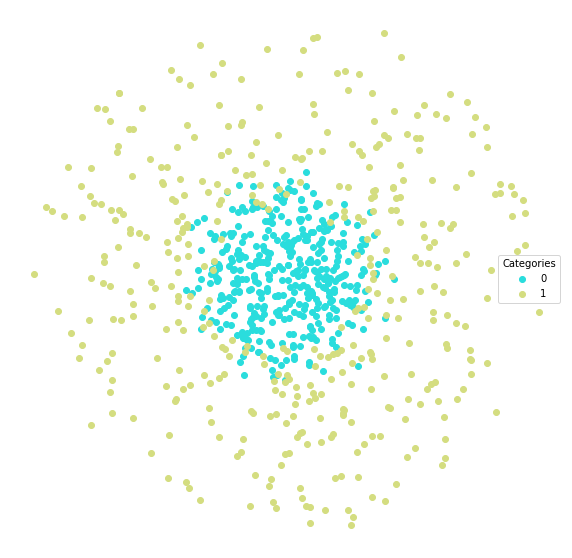

In [3]:
lucem_illud_2020.plotter(dfTrain)

## Training a Machine Learning algorithm

We can now pick a model, there are many more options in `scikit-learn`. These are just a few examples, which array along the machine learning "tribes" described in Pedro Domingos _The Master Algorithm_.

Uncomment (remove the # in front of) each algorithm one at a time, then run the cell and subsequent cells to evaluate how it learns to understand the data.

In [60]:
clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance

In [142]:
#Bayes
clf_bayes = sklearn.naive_bayes.GaussianNB()

#Analogizes
clf_linear = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
clf_poly = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf_kneighbors = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
clf_classical = sklearn.linear_model.LogisticRegression()

#Symbolists
clf_decisiontree = sklearn.tree.DecisionTreeClassifier()
clf_randomforest = sklearn.ensemble.RandomForestClassifier()

#Connectionists
clf_connectionist = sklearn.neural_network.MLPClassifier()

#Ensemble
clf_ensemble = sklearn.ensemble.GradientBoostingClassifier()

Now we fit the model by giving it our training data

In [61]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')

## Algorithm evaluation

We can look at few measurements of each classifier's performance by using the testing set

In [6]:
lucem_illud_2020.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.1,0.89976,0.894231,0.860328,0.911765
1,0.1,0.89976,0.906250,0.859528,0.887755


This lets us look at which classes do better:

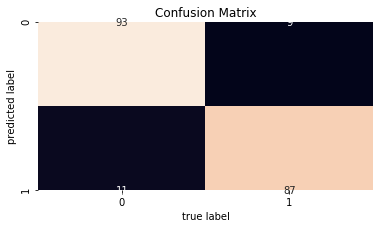

In [7]:
lucem_illud_2020.plotConfusionMatrix(clf, dfTest)

The greater the area under the curve the better.

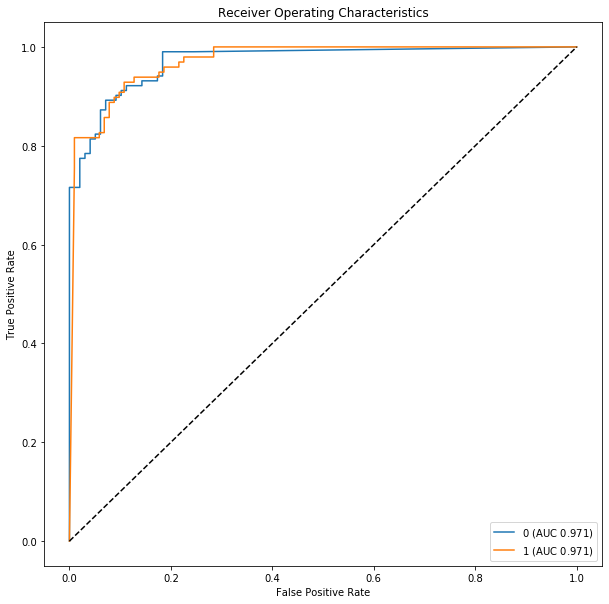

In [8]:
lucem_illud_2020.plotMultiROC(clf, dfTest)

We can also look at the regions the classifer identifies as one class or the other:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


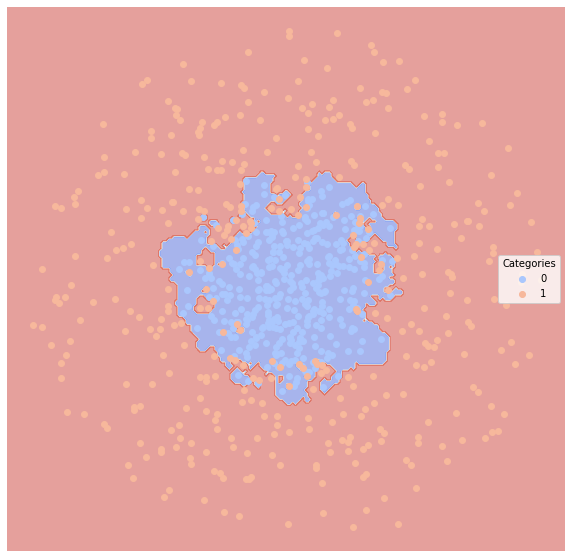

In [62]:
lucem_illud_2020.plotregions(clf, dfTrain)

## Now we do the same for real data

Available data sets include:
+ Reddit threads "classified" by thread topic
+ 20 newsgroups "classified" by group topic
+ Senate press releases "classified" by Senator (2 senators)
+ Senate press releases "classified" by Senator (5 senators)
+ Emails classified as Spam or Ham

In [180]:
dfTrain_reddit, dfTest_reddit = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadReddit())
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadNewsGroups())
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSenateSmall())
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSenateLarge())
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSpam())

Loading Reddit data
Converting to vectors


In [159]:
dfTrain_news, dfTest_news= lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadNewsGroups())


Loading data for: comp.sys.mac.hardware
Loading data for: comp.windows.x
Loading data for: misc.forsale
Loading data for: rec.autos
Converting to vectors


In [164]:
dfTrain_senatesmall, dfTest_senatesmall = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSenateSmall())

Loading senate data
Converting to vectors


In [165]:
dfTrain_senatelarge, dfTest_senatelarge = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSenateLarge())

Loading senator: Kennedy
Loading senator: Kerry
Loading senator: Klobuchar
Loading senator: Kohl
Loading senator: Kyl
Converting to vectors


In [166]:
dfTrain_spam, dfTest_spam = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSpam())

Loading Spam
Loading Ham
Converting to vectors


In [49]:
#Bayes
clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up, but lose ROC
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

In [50]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

GaussianNB(priors=None, var_smoothing=1e-09)

In [51]:
lucem_illud_2020.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Tales From Tech Support,0.084639,0.852936,0.904762,0.727003,0.730769
Weeaboo Tales,0.238245,0.807760,0.521127,0.495363,0.902439
Bad Roommates,0.156740,0.742985,0.754386,0.523468,0.544304
Relationships,0.191223,0.697751,0.666667,0.448328,0.475000


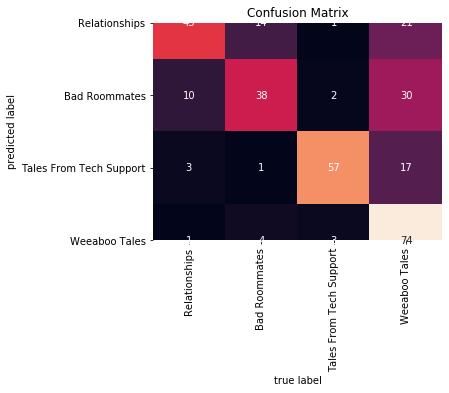

In [52]:
lucem_illud_2020.plotConfusionMatrix(clf, dfTest)

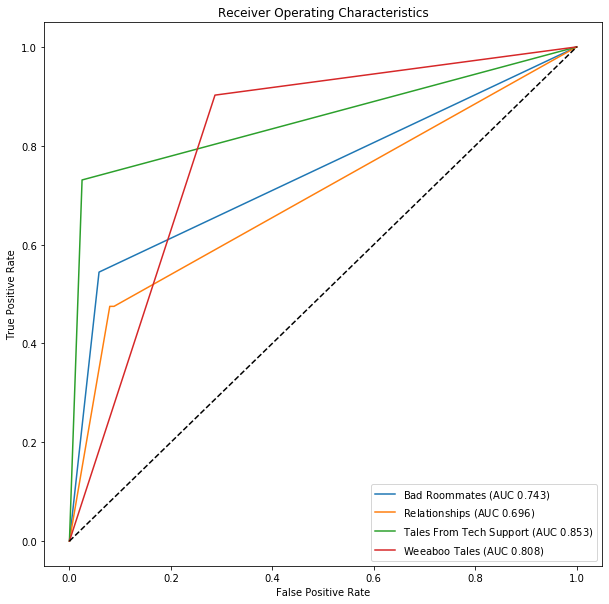

In [53]:
lucem_illud_2020.plotMultiROC(clf, dfTest)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

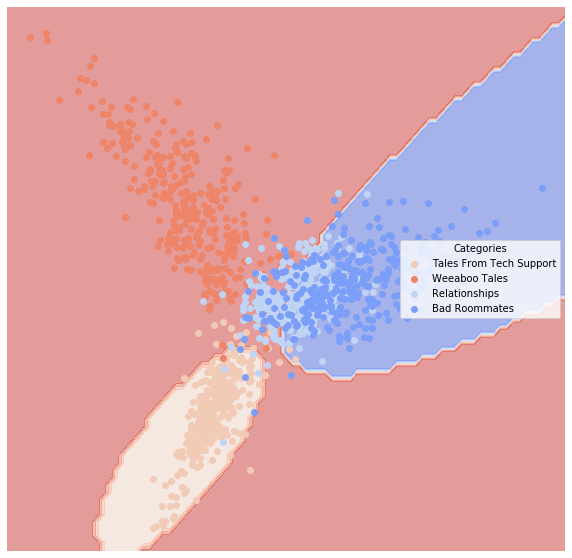

In [54]:
lucem_illud_2020.plotregions(clf, dfTrain)

In [140]:
def print_classifier_results(classifier,train,test): #define a function that print results for each classifier and dataset
    classifier.fit(np.stack(train['vect'], axis=0), train['category'])
    print(lucem_illud_2020.evaluateClassifier(classifier, test))
    print(lucem_illud_2020.plotConfusionMatrix(classifier, test))
    print(classifier)

          Error_Rate      AUC  Precision  Average_Precision    Recall
Category                                                             
0               0.57  0.43339   0.430894           0.455437  0.546392
1               0.57  0.43339   0.428571           0.487309  0.320388


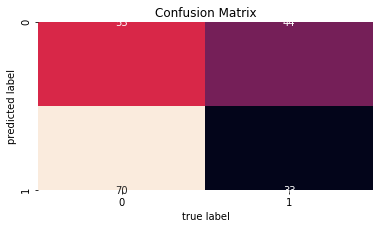

None
GaussianNB(priors=None, var_smoothing=1e-09)
          Error_Rate      AUC  Precision  Average_Precision    Recall
Category                                                             
0               0.58  0.42218   0.417391           0.451544  0.494845
1               0.58  0.42218   0.423529           0.483030  0.349515


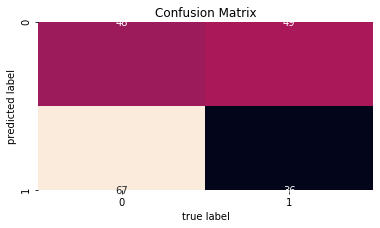

None
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.53  0.474627   0.465649           0.472831  0.628866
1               0.53  0.474627   0.478261           0.503229  0.320388


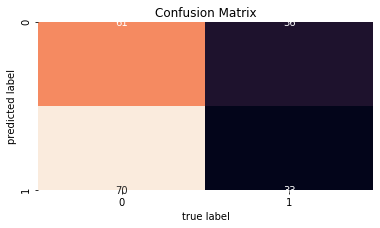

None
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.525  0.475578   0.461538           0.473390  0.494845
1              0.525  0.475578   0.489583           0.503402  0.456311


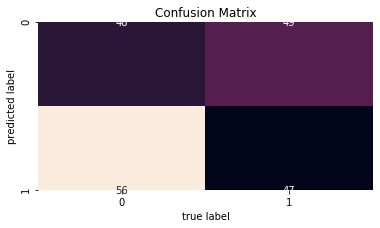

None
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.585  0.418226   0.418033           0.449790  0.525773
1              0.585  0.418226   0.410256           0.482458  0.310680


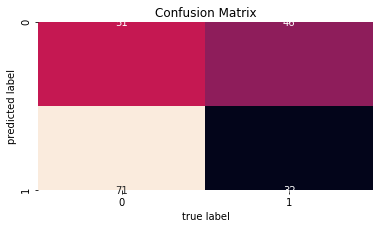

None
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.505  0.496497   0.481818           0.483261  0.546392
1              0.505  0.496497   0.511111           0.513263  0.446602


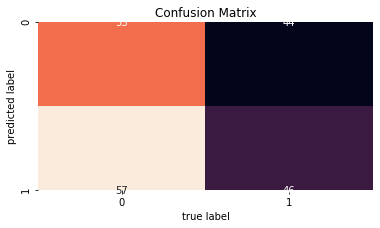

None
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.515  0.485587   0.471154           0.478006  0.505155
1              0.515  0.485587   0.500000           0.508010  0.466019


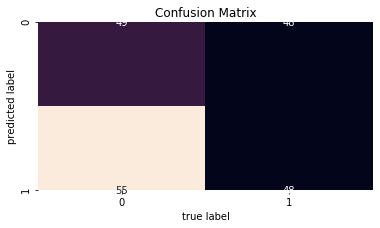

None
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.54  0.457412   0.433735           0.465974  0.371134
1               0.54  0.457412   0.478632           0.495227  0.543689


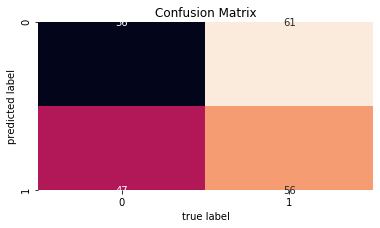

None
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.505  0.494395   0.479167           0.482234  0.474227
1              0.505  0.494395   0.509615           0.512229  0.514563


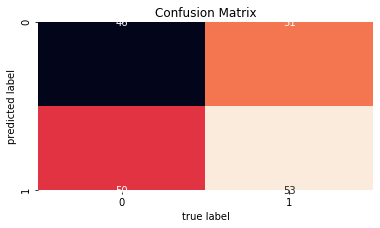

None
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [145]:
#random two classes, noise =0.3
print_classifier_results(clf_bayes,dfTrain1, dfTest1)
print_classifier_results(clf_linear,dfTrain1, dfTest1)
print_classifier_results(clf_poly,dfTrain1, dfTest1)
print_classifier_results(clf_kneighbors,dfTrain1, dfTest1)
print_classifier_results(clf_classical,dfTrain1, dfTest1)
print_classifier_results(clf_decisiontree,dfTrain1, dfTest1) #also lowest error rate
print_classifier_results(clf_randomforest,dfTrain1, dfTest1)
print_classifier_results(clf_connectionist,dfTrain1, dfTest1)
print_classifier_results(clf_ensemble,dfTrain1, dfTest1) #lowest Gradient Boosting Classifier the lowest error and highest precision 

          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.15  0.848157   0.830357           0.797531  0.894231
1               0.15  0.848157   0.875000           0.796823  0.802083


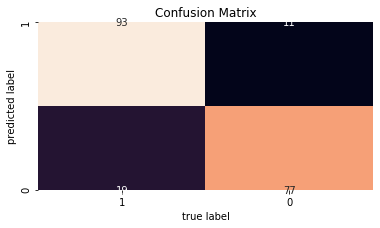

None
GaussianNB(priors=None, var_smoothing=1e-09)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.145  0.853365   0.837838           0.804220  0.894231
1              0.145  0.853365   0.876404           0.802079  0.812500


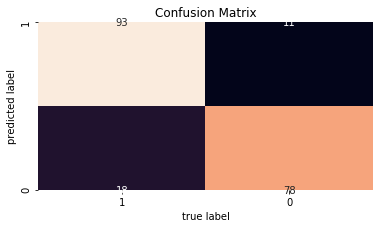

None
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.155  0.841346   0.801653           0.782695  0.932692
1              0.155  0.841346   0.911392           0.803544  0.750000


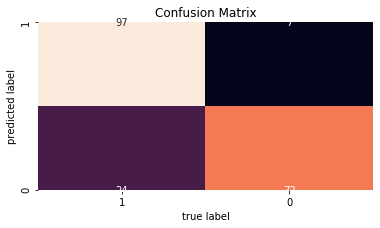

None
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.17  0.827324   0.801724           0.771926  0.894231
1               0.17  0.827324   0.869048           0.775838  0.760417


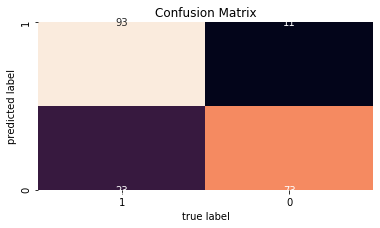

None
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.145  0.853365   0.837838           0.804220  0.894231
1              0.145  0.853365   0.876404           0.802079  0.812500


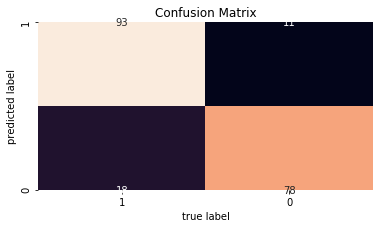

None
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.19  0.808894   0.805556           0.758878  0.836538
1               0.19  0.808894   0.815217           0.741889  0.781250


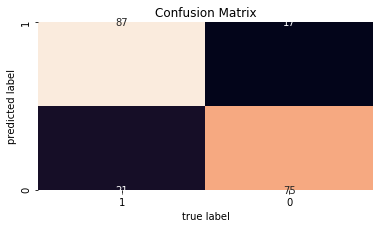

None
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.165  0.833333   0.819820           0.782342  0.875000
1              0.165  0.833333   0.853933           0.776030  0.791667


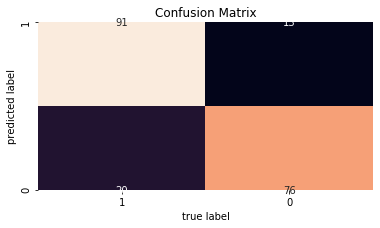

None
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.145  0.853365   0.837838           0.804220  0.894231
1              0.145  0.853365   0.876404           0.802079  0.812500


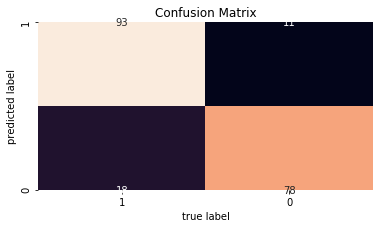

None
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.16  0.838141   0.821429           0.786648  0.884615
1               0.16  0.838141   0.863636           0.783712  0.791667


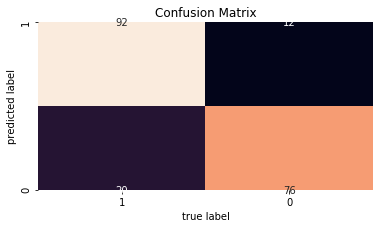

None
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [147]:
#linearly split, noise =0.3
print_classifier_results(clf_bayes,dfTrain2, dfTest2)
print_classifier_results(clf_linear,dfTrain2, dfTest2) #linear SVC low error rate
print_classifier_results(clf_poly,dfTrain2, dfTest2)
print_classifier_results(clf_kneighbors,dfTrain2, dfTest2)
print_classifier_results(clf_classical,dfTrain2, dfTest2) #classical linear model regression - low error rate
print_classifier_results(clf_decisiontree,dfTrain2, dfTest2) 
print_classifier_results(clf_randomforest,dfTrain2, dfTest2)
print_classifier_results(clf_connectionist,dfTrain2, dfTest2) #connectionist - MLP classifier low error rate
print_classifier_results(clf_ensemble,dfTrain2, dfTest2)  

          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.53  0.467587   0.447368           0.475209  0.346939
1               0.53  0.467587   0.483871           0.494630  0.588235


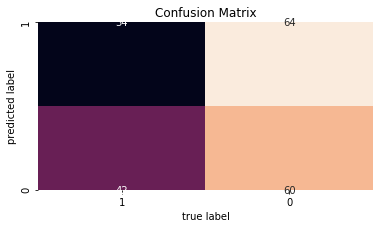

None
GaussianNB(priors=None, var_smoothing=1e-09)
          Error_Rate      AUC  Precision  Average_Precision    Recall
Category                                                             
0              0.475  0.52591   0.513761           0.503578  0.571429
1              0.475  0.52591   0.538462           0.523673  0.480392


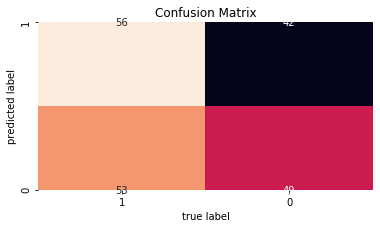

None
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.215  0.781613   0.923077           0.755149  0.612245
1              0.215  0.781613   0.718519           0.708297  0.950980


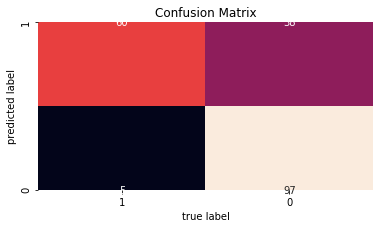

None
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.12  0.879152   0.911111           0.842358  0.836735
1               0.12  0.879152   0.854545           0.827522  0.921569


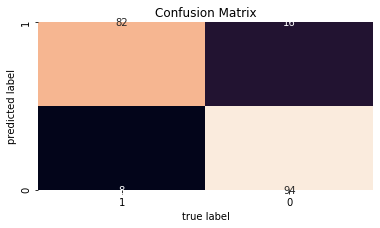

None
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.495  0.504502   0.494737           0.492272  0.479592
1              0.495  0.504502   0.514286           0.512269  0.529412


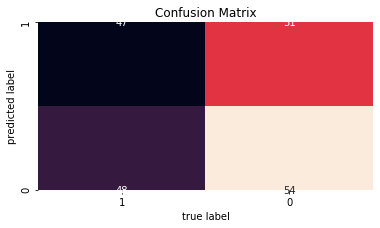

None
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
          Error_Rate      AUC  Precision  Average_Precision    Recall
Category                                                             
0               0.15  0.84994   0.846939           0.792305  0.846939
1               0.15  0.84994   0.852941           0.802509  0.852941


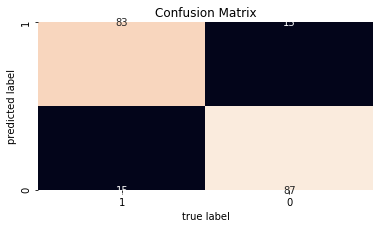

None
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
          Error_Rate      AUC  Precision  Average_Precision    Recall
Category                                                             
0              0.125  0.87445   0.892473           0.830870  0.846939
1              0.125  0.87445   0.859813           0.825518  0.901961


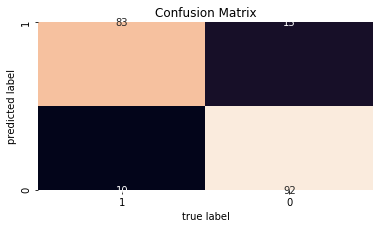

None
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.11  0.888956   0.931818           0.859685  0.836735
1               0.11  0.888956   0.857143           0.836723  0.941176


/Users/wanxing/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


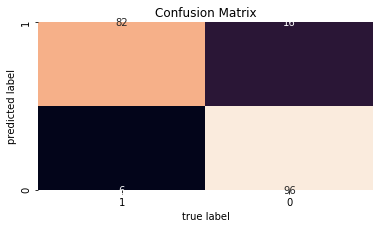

None
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
          Error_Rate      AUC  Precision  Average_Precision    Recall
Category                                                             
0              0.125  0.87385   0.919540           0.840645  0.816327
1              0.125  0.87385   0.840708           0.818012  0.931373


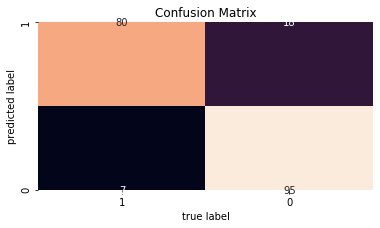

None
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [149]:
#oppositely split, noise 0.3
print_classifier_results(clf_bayes,dfTrain3, dfTest3)
print_classifier_results(clf_linear,dfTrain3, dfTest3)
print_classifier_results(clf_poly,dfTrain3, dfTest3)
print_classifier_results(clf_kneighbors,dfTrain3, dfTest3)#2 lowest error
print_classifier_results(clf_classical,dfTrain3, dfTest3) 
print_classifier_results(clf_decisiontree,dfTrain3, dfTest3) 
print_classifier_results(clf_randomforest,dfTrain3, dfTest3) #3 low error
print_classifier_results(clf_connectionist,dfTrain3, dfTest3) #1 lowest error
print_classifier_results(clf_ensemble,dfTrain3, dfTest3)  #3 low error

          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.125  0.876239   0.839623           0.810375  0.917526
1              0.125  0.876239   0.914894           0.848892  0.834951


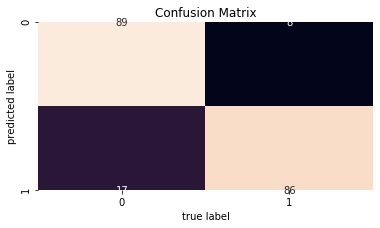

None
GaussianNB(priors=None, var_smoothing=1e-09)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.395  0.613802   0.556962           0.550285  0.907216
1              0.395  0.613802   0.785714           0.601734  0.320388


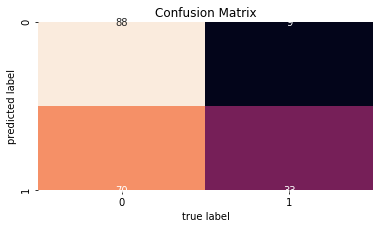

None
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.415  0.597087   0.538889           0.538889  1.000000
1              0.415  0.597087   1.000000           0.609175  0.194175


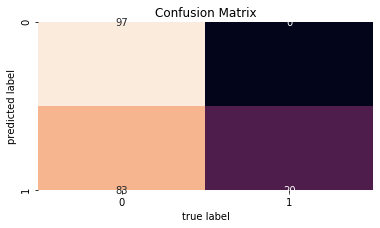

None
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.165  0.835302       0.82           0.768196  0.845361
1              0.165  0.835302       0.85           0.791456  0.825243


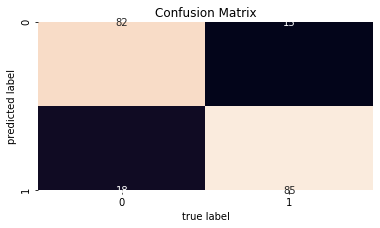

None
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')
          Error_Rate      AUC  Precision  Average_Precision    Recall
Category                                                             
0               0.48  0.52257   0.504274           0.496723  0.608247
1               0.48  0.52257   0.542169           0.526870  0.436893


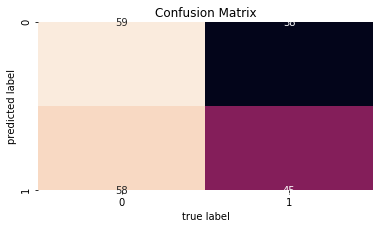

None
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.18  0.818937   0.835165           0.759356  0.783505
1               0.18  0.818937   0.807339           0.764766  0.854369


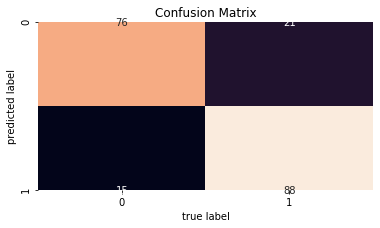

None
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.135  0.865029   0.857143           0.807268  0.865979
1              0.135  0.865029   0.872549           0.823950  0.864078


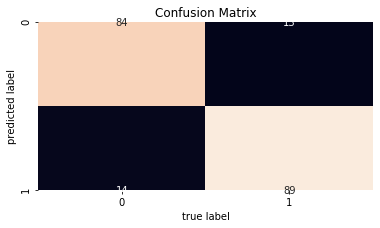

None
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.12  0.881393   0.841121           0.815422  0.927835
1               0.12  0.881393   0.924731           0.857106  0.834951


/Users/wanxing/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


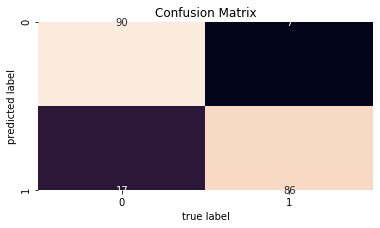

None
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.14  0.859574   0.863158            0.80468  0.845361
1               0.14  0.859574   0.857143            0.81396  0.873786


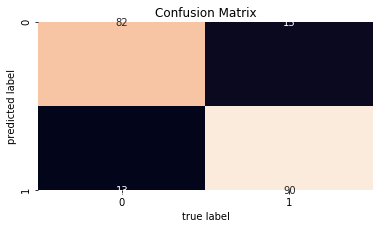

None
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [150]:
#targetsplit, one class nested with two others, noise 0.3
print_classifier_results(clf_bayes,dfTrain4, dfTest4) #2 low error
print_classifier_results(clf_linear,dfTrain4, dfTest4)
print_classifier_results(clf_poly,dfTrain4, dfTest4)
print_classifier_results(clf_kneighbors,dfTrain4, dfTest4)
print_classifier_results(clf_classical,dfTrain4, dfTest4)
print_classifier_results(clf_decisiontree,dfTrain4, dfTest4) 
print_classifier_results(clf_randomforest,dfTrain4, dfTest4) #3 low
print_classifier_results(clf_connectionist,dfTrain4, dfTest4)#lowest
print_classifier_results(clf_ensemble,dfTrain4, dfTest4)  

          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.016  0.971094   0.981818           0.942144  0.947368
1              0.000  1.000000   1.000000           1.000000  1.000000
2              0.000  1.000000   1.000000           1.000000  1.000000
3              0.010  0.987205   0.973451           0.960068  0.982143
4              0.014  0.983105   0.947917           0.931531  0.978495


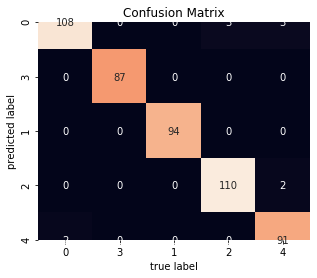

None
GaussianNB(priors=None, var_smoothing=1e-09)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.016  0.968003   0.990741           0.943906  0.938596
1              0.000  1.000000   1.000000           1.000000  1.000000
2              0.000  1.000000   1.000000           1.000000  1.000000
3              0.012  0.985917   0.964912           0.951682  0.982143
4              0.012  0.988481   0.948454           0.940255  0.989247


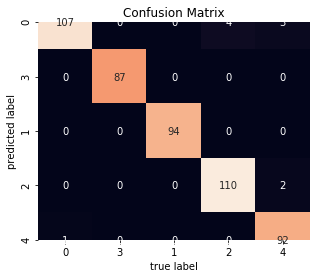

None
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.016  0.971094   0.981818           0.942144  0.947368
1              0.012  0.992736   0.935484           0.935484  1.000000
2              0.000  1.000000   1.000000           1.000000  1.000000
3              0.012  0.982741   0.973214           0.953146  0.973214
4              0.016  0.969433   0.967033           0.925042  0.946237


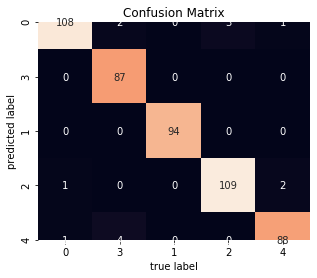

None
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.024  0.950459   0.990385           0.916821  0.903509
1              0.000  1.000000   1.000000           1.000000  1.000000
2              0.000  1.000000   1.000000           1.000000  1.000000
3              0.014  0.984628   0.956522           0.943441  0.982143
4              0.018  0.984796   0.920000           0.912108  0.989247


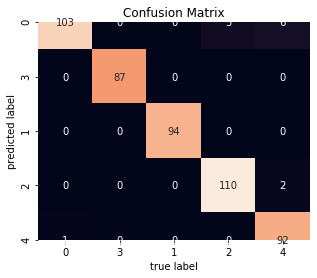

None
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.016  0.968003   0.990741           0.943906  0.938596
1              0.000  1.000000   1.000000           1.000000  1.000000
2              0.000  1.000000   1.000000           1.000000  1.000000
3              0.010  0.987205   0.973451           0.960068  0.982143
4              0.014  0.987253   0.938776           0.930681  0.989247


/Users/wanxing/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


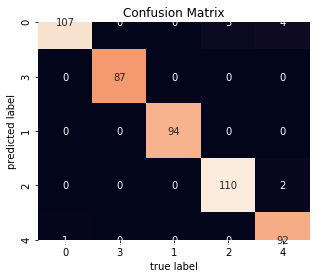

None
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.040  0.930824   0.943396           0.855541  0.877193
1              0.002  0.998789   0.988636           0.988636  1.000000
2              0.000  1.000000   1.000000           1.000000  1.000000
3              0.022  0.973122   0.939130           0.913590  0.964286
4              0.028  0.962062   0.907216           0.868441  0.946237


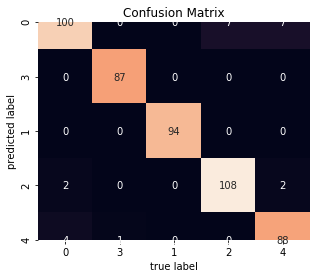

None
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.024  0.953550   0.981132           0.915068  0.912281
1              0.000  1.000000   1.000000           1.000000  1.000000
2              0.000  1.000000   1.000000           1.000000  1.000000
3              0.016  0.980164   0.956140           0.936529  0.973214
4              0.016  0.986024   0.929293           0.921301  0.989247


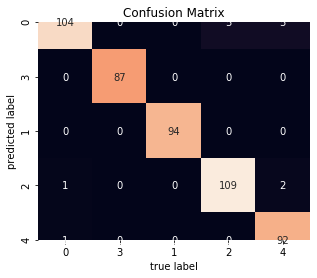

None
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


/Users/wanxing/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.020  0.962322   0.981481           0.928606  0.929825
1              0.000  1.000000   1.000000           1.000000  1.000000
2              0.000  1.000000   1.000000           1.000000  1.000000
3              0.012  0.985917   0.964912           0.951682  0.982143
4              0.016  0.981876   0.938144           0.921969  0.978495


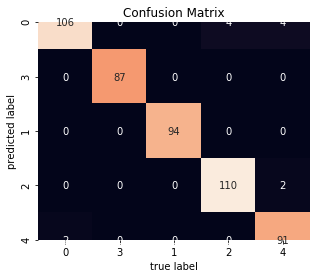

None
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.020  0.959231   0.990566           0.930363  0.921053
1              0.002  0.998789   0.988636           0.988636  1.000000
2              0.000  1.000000   1.000000           1.000000  1.000000
3              0.012  0.985917   0.964912           0.951682  0.982143
4              0.018  0.980648   0.928571  

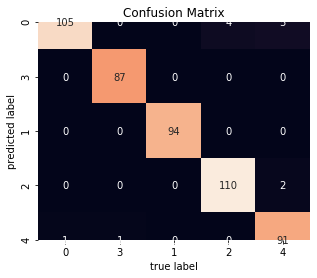

None
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [151]:
#5 classes as bivariate Gaussians, noise 0.3
print_classifier_results(clf_bayes,dfTrain5, dfTest5)
print_classifier_results(clf_linear,dfTrain5, dfTest5)
print_classifier_results(clf_poly,dfTrain5, dfTest5) #performs relatively well in confusion matrix
print_classifier_results(clf_kneighbors,dfTrain5, dfTest5)
print_classifier_results(clf_classical,dfTrain5, dfTest5)
print_classifier_results(clf_decisiontree,dfTrain5, dfTest5) 
print_classifier_results(clf_randomforest,dfTrain5, dfTest5)
print_classifier_results(clf_connectionist,dfTrain5, dfTest5)
print_classifier_results(clf_ensemble,dfTrain5, dfTest5)  

          Error_Rate     AUC  Precision  Average_Precision    Recall
Category                                                            
0              0.495  0.5048   0.500000           0.497424  0.484848
1              0.495  0.5048   0.509615           0.507422  0.524752


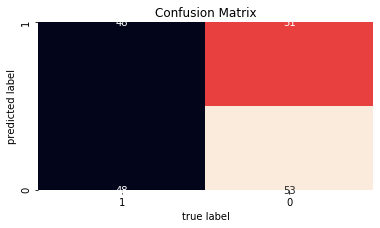

None
GaussianNB(priors=None, var_smoothing=1e-09)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.485  0.514701   0.510638           0.502582  0.484848
1              0.485  0.514701   0.518868           0.512552  0.544554


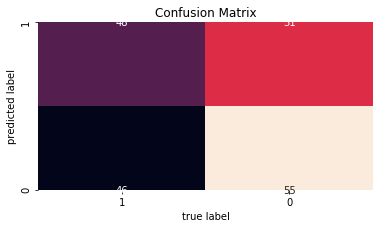

None
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.545  0.456596   0.462121           0.474741  0.616162
1              0.545  0.456596   0.441176           0.486043  0.297030


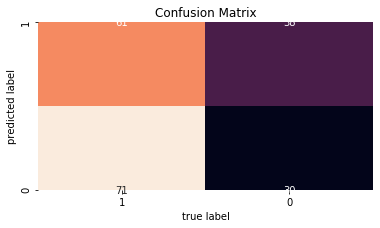

None
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.555  0.444694    0.43617           0.470636  0.414141
1              0.555  0.444694    0.45283           0.480206  0.475248


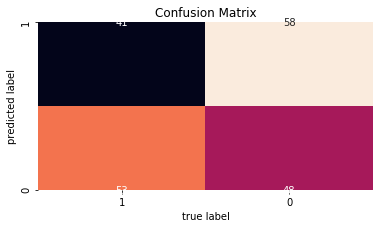

None
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.51  0.489849   0.484536           0.490032  0.474747
1               0.51  0.489849   0.495146           0.500024  0.504950


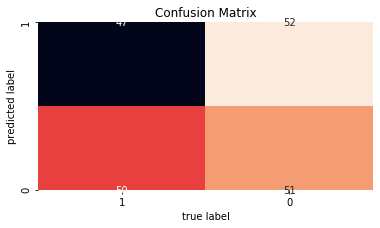

None
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.565  0.435294   0.433962           0.466639  0.464646
1              0.565  0.435294   0.436170           0.477059  0.405941


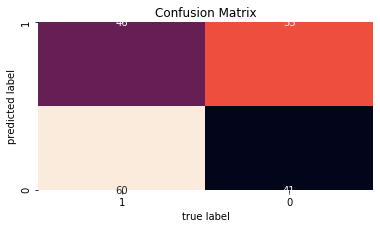

None
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.61  0.390139   0.388350           0.451909  0.404040
1               0.61  0.390139   0.391753           0.462392  0.376238


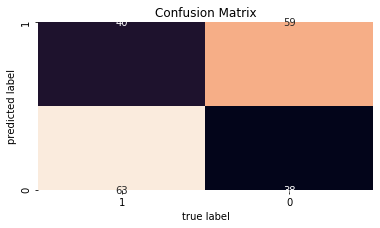

None
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.51  0.489949   0.484848           0.490078  0.484848
1               0.51  0.489949   0.495050           0.500074  0.495050


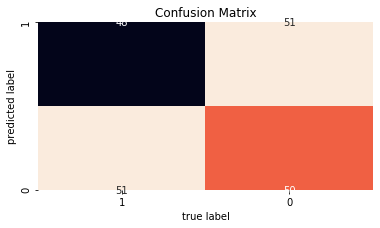

None
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.59  0.409841   0.402062           0.458388  0.393939
1               0.59  0.409841   0.417476           0.467737  0.425743


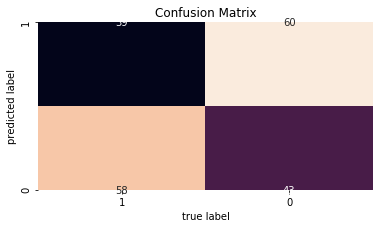

None
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [152]:
print_classifier_results(clf_bayes,dfTrain6, dfTest6)
print_classifier_results(clf_linear,dfTrain6, dfTest6) #lowest error, linear SVC
print_classifier_results(clf_poly,dfTrain6, dfTest6)
print_classifier_results(clf_kneighbors,dfTrain6, dfTest6)
print_classifier_results(clf_classical,dfTrain6, dfTest6)
print_classifier_results(clf_decisiontree,dfTrain6, dfTest6) 
print_classifier_results(clf_randomforest,dfTrain6, dfTest6)
print_classifier_results(clf_connectionist,dfTrain6, dfTest6)
print_classifier_results(clf_ensemble,dfTrain6, dfTest6)  

          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.22  0.780102   0.767677           0.706479  0.783505
1               0.22  0.780102   0.792079           0.730207  0.776699


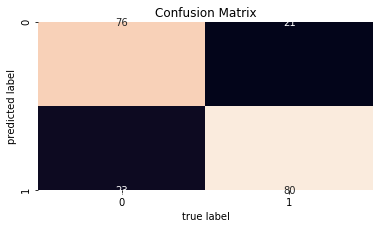

None
GaussianNB(priors=None, var_smoothing=1e-09)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.22  0.780102   0.767677           0.706479  0.783505
1               0.22  0.780102   0.792079           0.730207  0.776699


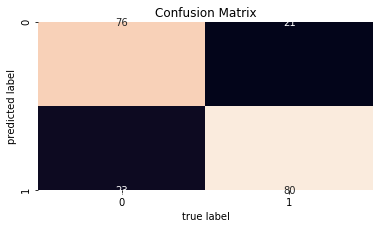

None
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.22  0.782805   0.726496            0.69662  0.876289
1               0.22  0.782805   0.855422            0.74966  0.689320


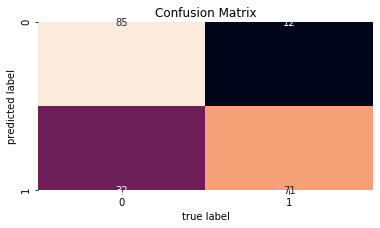

None
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.275  0.726404   0.694444           0.646942  0.773196
1              0.275  0.726404   0.760870           0.682096  0.679612


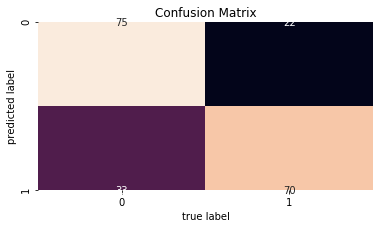

None
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.225  0.774947   0.765306           0.701732  0.773196
1              0.225  0.774947   0.784314           0.724176  0.776699


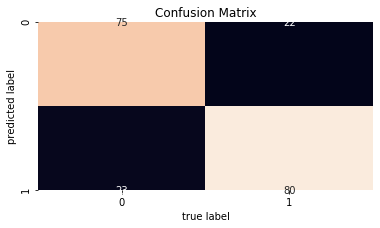

None
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.295  0.706085   0.679245           0.629182  0.742268
1              0.295  0.706085   0.734043           0.661737  0.669903


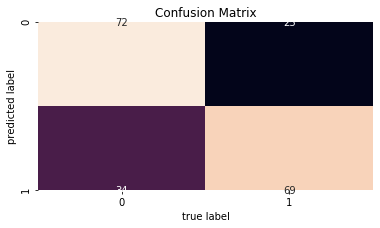

None
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.27  0.732159   0.690265           0.650059  0.804124
1               0.27  0.732159   0.781609           0.691014  0.660194


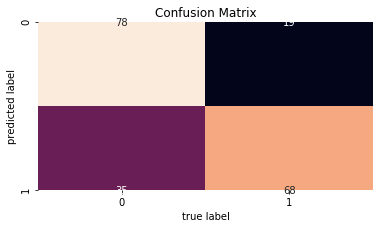

None
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.22  0.780102   0.767677           0.706479  0.783505
1               0.22  0.780102   0.792079           0.730207  0.776699


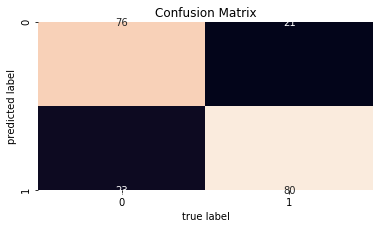

None
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.255  0.747022   0.705357           0.664466  0.814433
1              0.255  0.747022   0.795455           0.705600  0.679612


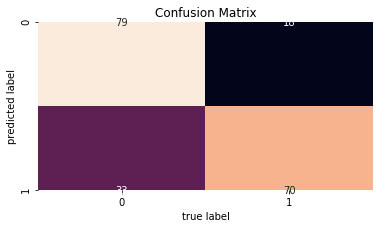

None
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [153]:
print_classifier_results(clf_bayes,dfTrain7, dfTest7) #low error
print_classifier_results(clf_linear,dfTrain7, dfTest7) #same low error
print_classifier_results(clf_poly,dfTrain7, dfTest7) #same low error, slightly higher AUC
print_classifier_results(clf_kneighbors,dfTrain7, dfTest7)
print_classifier_results(clf_classical,dfTrain7, dfTest7)
print_classifier_results(clf_decisiontree,dfTrain7, dfTest7) 
print_classifier_results(clf_randomforest,dfTrain7, dfTest7)
print_classifier_results(clf_connectionist,dfTrain7, dfTest7) #low
print_classifier_results(clf_ensemble,dfTrain7, dfTest7) 

          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.485  0.524561   0.492754           0.487708  0.715789
1              0.485  0.524561   0.564516           0.538172  0.333333


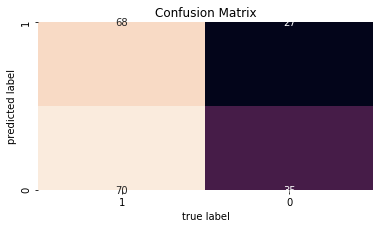

None
GaussianNB(priors=None, var_smoothing=1e-09)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.465  0.543609   0.507463           0.498236  0.715789
1              0.465  0.543609   0.590909           0.549481  0.371429


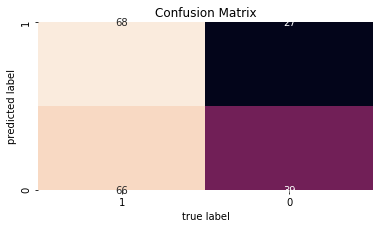

None
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.27  0.721303   0.825397           0.666796  0.547368
1               0.27  0.721303   0.686131           0.669251  0.895238


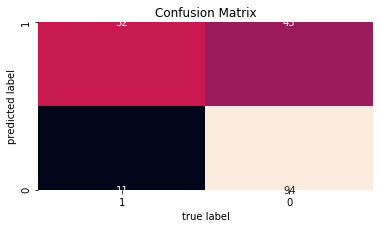

None
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.27  0.730827   0.702970           0.645378  0.747368
1               0.27  0.730827   0.757576           0.691126  0.714286


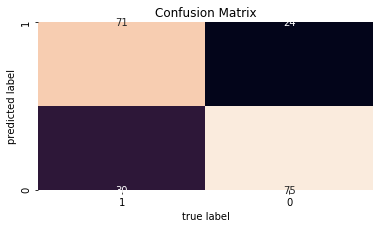

None
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.475  0.533083   0.500000           0.492368  0.694737
1              0.475  0.533083   0.573529           0.543025  0.371429


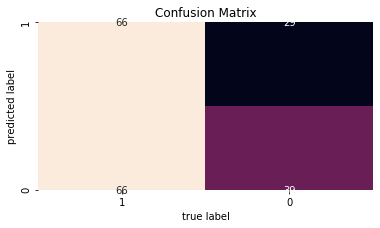

None
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.295  0.705514       0.68           0.621737  0.715789
1              0.295  0.705514       0.73           0.667524  0.695238


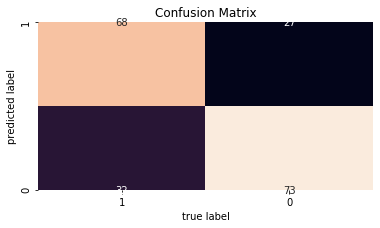

None
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.29  0.711278   0.679612           0.625766  0.736842
1               0.29  0.711278   0.742268           0.673984  0.685714


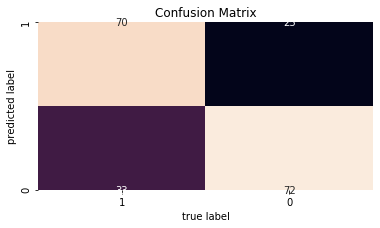

None
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.235  0.765664       0.74           0.681421  0.778947
1              0.235  0.765664       0.79           0.724381  0.752381


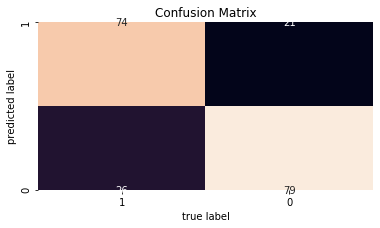

None
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.275  0.728571   0.678571           0.637857  0.800000
1              0.275  0.728571   0.784091           0.695260  0.657143


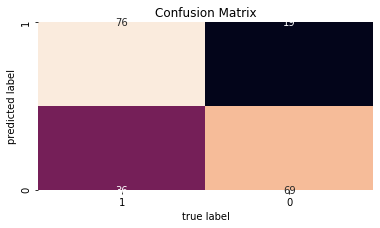

None
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [154]:
print_classifier_results(clf_bayes,dfTrain8, dfTest8)
print_classifier_results(clf_linear,dfTrain8, dfTest8)
print_classifier_results(clf_poly,dfTrain8, dfTest8) #2nd low error
print_classifier_results(clf_kneighbors,dfTrain8, dfTest8) #2nd low error
print_classifier_results(clf_classical,dfTrain8, dfTest8)
print_classifier_results(clf_decisiontree,dfTrain8, dfTest8) 
print_classifier_results(clf_randomforest,dfTrain8, dfTest8)
print_classifier_results(clf_connectionist,dfTrain8, dfTest8) #lowest error
print_classifier_results(clf_ensemble,dfTrain8, dfTest8) 

          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.235  0.760813   0.771930           0.728209  0.807339
1              0.235  0.760813   0.755814           0.669867  0.714286


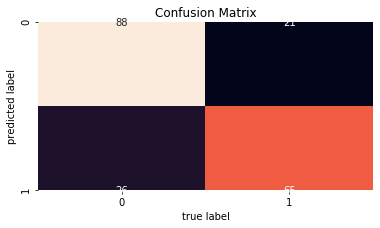

None
GaussianNB(priors=None, var_smoothing=1e-09)
          Error_Rate  AUC  Precision  Average_Precision  Recall
Category                                                       
0              0.545  0.5      0.000              0.545     0.0
1              0.545  0.5      0.455              0.455     1.0


/Users/wanxing/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


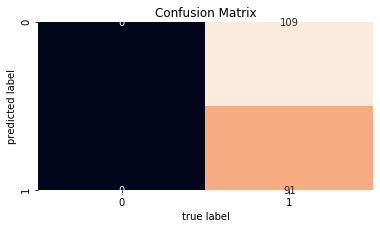

None
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


/Users/wanxing/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


          Error_Rate  AUC  Precision  Average_Precision  Recall
Category                                                       
0              0.545  0.5      0.000              0.545     0.0
1              0.545  0.5      0.455              0.455     1.0


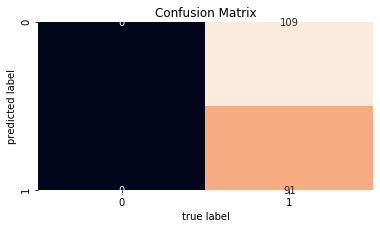

None
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.345  0.660803   0.722222           0.650683  0.596330
1              0.345  0.660803   0.600000           0.560165  0.725275


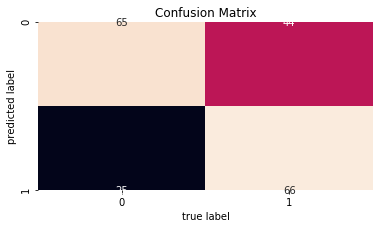

None
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.53  0.489263   0.526316           0.539858  0.275229
1               0.53  0.489263   0.447552           0.449762  0.703297


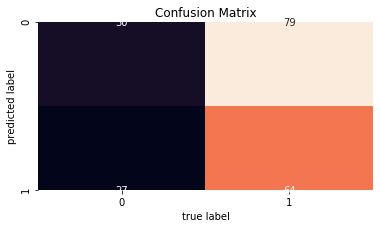

None
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.325  0.682781   0.755814           0.670715  0.596330
1              0.325  0.682781   0.614035           0.577335  0.769231


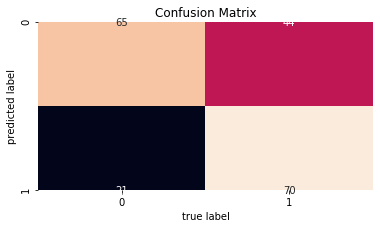

None
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.285  0.716756       0.76           0.694908  0.697248
1              0.285  0.716756       0.67           0.613297  0.736264


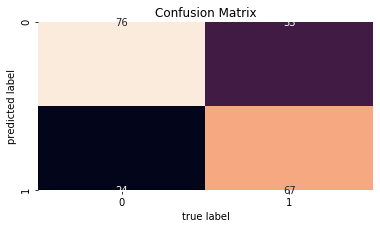

None
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.265  0.734197   0.764151           0.707855  0.743119
1              0.265  0.734197   0.702128           0.634235  0.725275


/Users/wanxing/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


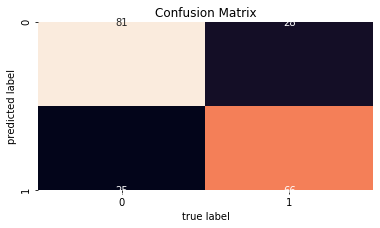

None
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.29  0.709447   0.742857           0.686586  0.715596
1               0.29  0.709447   0.673684           0.608800  0.703297


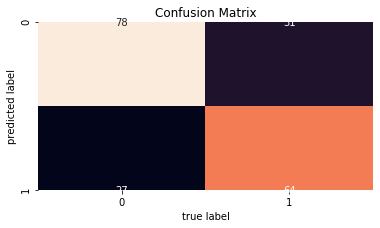

None
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [155]:
print_classifier_results(clf_bayes,dfTrain9, dfTest9) #lowest error rate, high AUC
print_classifier_results(clf_linear,dfTrain9, dfTest9)
print_classifier_results(clf_poly,dfTrain9, dfTest9)
print_classifier_results(clf_kneighbors,dfTrain9, dfTest9)
print_classifier_results(clf_classical,dfTrain9, dfTest9)
print_classifier_results(clf_decisiontree,dfTrain9, dfTest9) 
print_classifier_results(clf_randomforest,dfTrain9, dfTest9)
print_classifier_results(clf_connectionist,dfTrain9, dfTest9)
print_classifier_results(clf_ensemble,dfTrain9, dfTest9) 

          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.002  0.994444   1.000000           0.990889  0.988889
1              0.002  0.998753   0.990000           0.990000  1.000000
2              0.004  0.993750   0.990000           0.982100  0.990000
3              0.004  0.993930   0.990385           0.982862  0.990385
4              0.000  1.000000   1.000000           1.000000  1.000000


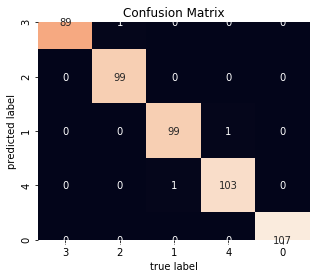

None
GaussianNB(priors=None, var_smoothing=1e-09)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.004  0.988889   1.000000           0.981778  0.977778
1              0.006  0.996259   0.970588           0.970588  1.000000
2              0.004  0.993750   0.990000           0.982100  0.990000
3              0.004  0.993930   0.990385           0.982862  0.990385
4              0.002  0.995327   1.000000           0.992654  0.990654


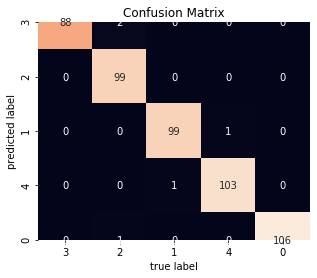

None
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.002  0.994444   1.000000           0.990889  0.988889
1              0.008  0.983602   0.989691           0.965700  0.969697
2              0.004  0.993750   0.990000           0.982100  0.990000
3              0.010  0.990142   0.962617           0.955361  0.990385
4              0.000  1.000000   1.000000           1.000000  1.000000


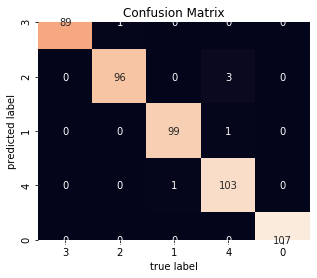

None
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.004  0.988889   1.000000           0.981778  0.977778
1              0.004  0.997506   0.980198           0.980198  1.000000
2              0.004  0.993750   0.990000           0.982100  0.990000
3              0.004  0.993930   0.990385           0.982862  0.990385
4              0.000  1.000000   1.000000           1.000000  1.000000


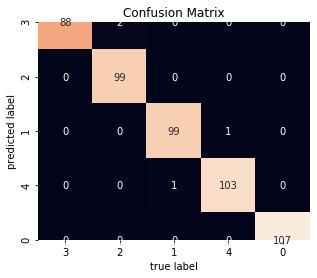

None
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.002  0.994444   1.000000           0.990889  0.988889
1              0.002  0.998753   0.990000           0.990000  1.000000
2              0.004  0.993750   0.990000           0.982100  0.990000
3              0.004  0.993930   0.990385           0.982862  0.990385
4              0.000  1.000000   1.000000           1.000000  1.000000


/Users/wanxing/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


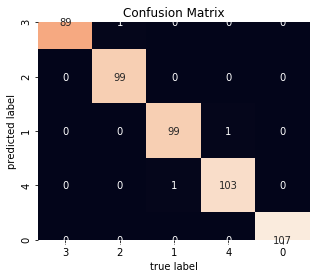

None
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.004  0.988889   1.000000           0.981778  0.977778
1              0.004  0.997506   0.980198           0.980198  1.000000
2              0.002  0.998750   0.990099           0.990099  1.000000
3              0.002  0.995192   1.000000           0.992385  0.990385
4              0.000  1.000000   1.000000           1.000000  1.000000


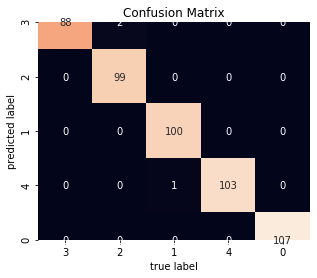

None
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.004  0.988889   1.000000           0.981778  0.977778
1              0.004  0.997506   0.980198           0.980198  1.000000
2              0.004  0.993750   0.990000           0.982100  0.990000
3              0.004  0.993930   0.990385           0.982862  0.990385
4              0.000  1.000000   1.000000           1.000000  1.000000


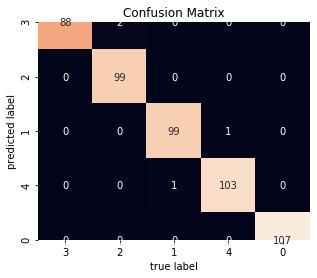

None
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.004  0.988889   1.000000           0.981778  0.977778
1              0.006  0.996259   0.970588           0.970588  1.000000
2              0.004  0.993750   0.990000           0.982100  0.990000
3              0.004  0.993930   0.990385           0.982862  0.990385
4              0.002  

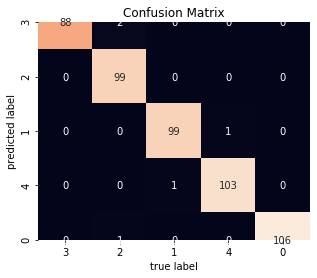

None
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.002  0.994444   1.000000           0.990889  0.988889
1              0.002  0.998753   0.990000           0.990000  1.000000
2              0.004  0.993750   0.990000           0.982100  0.990000
3              0.004  0.993930   0.990385           0.982862  0.990385
4              0.000  1.000000   1.000000  

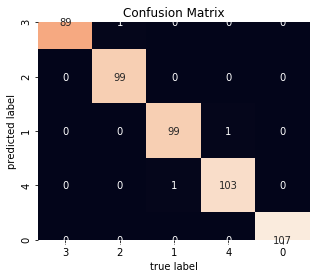

None
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [156]:
print_classifier_results(clf_bayes,dfTrain10, dfTest10) #1
print_classifier_results(clf_linear,dfTrain10, dfTest10)
print_classifier_results(clf_poly,dfTrain10, dfTest10)
print_classifier_results(clf_kneighbors,dfTrain10, dfTest10) 
print_classifier_results(clf_classical,dfTrain10, dfTest10) #1
print_classifier_results(clf_decisiontree,dfTrain10, dfTest10) #also good
print_classifier_results(clf_randomforest,dfTrain10, dfTest10)
print_classifier_results(clf_connectionist,dfTrain10, dfTest10)
print_classifier_results(clf_ensemble,dfTrain10, dfTest10) #also good

                         Error_Rate       AUC  Precision  Average_Precision  \
Category                                                                      
Tales From Tech Support    0.059561  0.900539   0.958904           0.830660   
Weeaboo Tales              0.216301  0.847002   0.484375           0.471424   
Bad Roommates              0.150470  0.783355   0.708333           0.547781   
Relationships              0.194357  0.685905   0.804348           0.496821   

                           Recall  
Category                           
Tales From Tech Support  0.813953  
Weeaboo Tales            0.953846  
Bad Roommates            0.653846  
Relationships            0.411111  


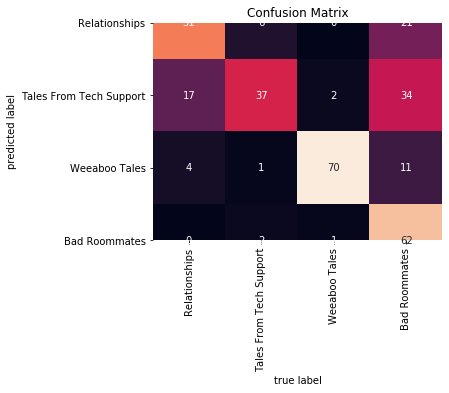

None
GaussianNB(priors=None, var_smoothing=1e-09)
                         Error_Rate       AUC  Precision  Average_Precision  \
Category                                                                      
Tales From Tech Support    0.012539  0.984080   0.976744           0.960299   
Weeaboo Tales              0.009404  0.976923   1.000000           0.963251   
Bad Roommates              0.028213  0.968321   0.925926           0.899718   
Relationships              0.031348  0.961305   0.944444           0.907649   

                           Recall  
Category                           
Tales From Tech Support  0.976744  
Weeaboo Tales            0.953846  
Bad Roommates            0.961538  
Relationships            0.944444  


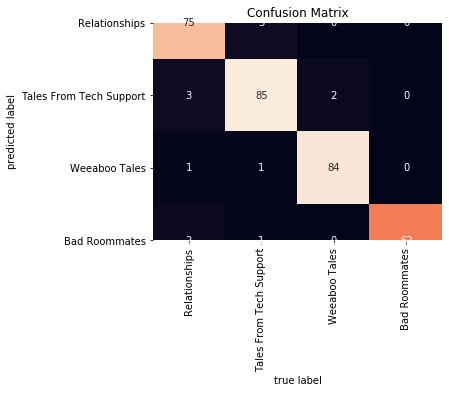

None
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
                         Error_Rate       AUC  Precision  Average_Precision  \
Category                                                                      
Tales From Tech Support    0.037618  0.966913   0.893617           0.879105   
Weeaboo Tales              0.043887  0.909479   0.947368           0.821527   
Bad Roommates              0.056426  0.919300   0.894737           0.811375   
Relationships              0.062696  0.925983   0.880435           0.820604   

                           Recall  
Category                           
Tales From Tech Support  0.976744  
Weeaboo Tales            0.830769  
Bad Roommates            0.871795  
Relationships            0.900000  


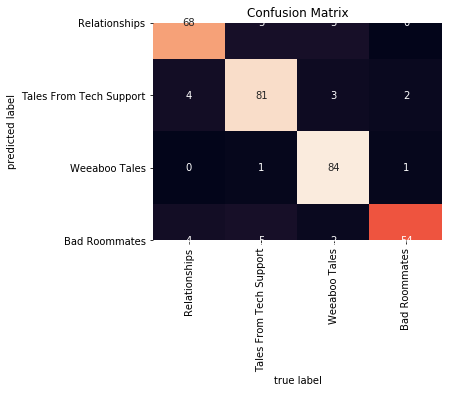

None
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
                         Error_Rate       AUC  Precision  Average_Precision  \
Category                                                                      
Tales From Tech Support    0.043887  0.933277   0.950000           0.870883   
Weeaboo Tales              0.084639  0.906784   0.743590           0.685454   
Bad Roommates              0.068966  0.919672   0.833333           0.772942   
Relationships              0.090909  0.865866   0.896104           0.752844   

                           Recall  
Category                           
Tales From Tech Support  0.883721  
Weeaboo Tales            0.892308  
Bad Roommates            0.897436  
Relationships            0.766667  


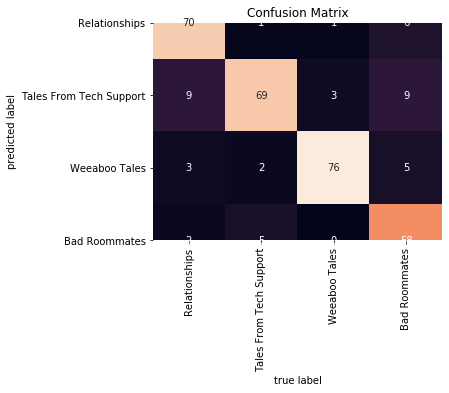

None
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')
                         Error_Rate       AUC  Precision  Average_Precision  \
Category                                                                      
Tales From Tech Support    0.006270  0.995708   0.977273           0.977273   
Weeaboo Tales              0.018809  0.959570   0.983607           0.923618   
Bad Roommates              0.021944  0.976806   0.938272           0.920483   
Relationships              0.034483  0.955750   0.943820           0.899708   

                           Recall  
Category                           
Tales From Tech Support  1.000000  
Weeaboo Tales            0.923077  
Bad Roommates            0.974359  
Relationships            0.933333  


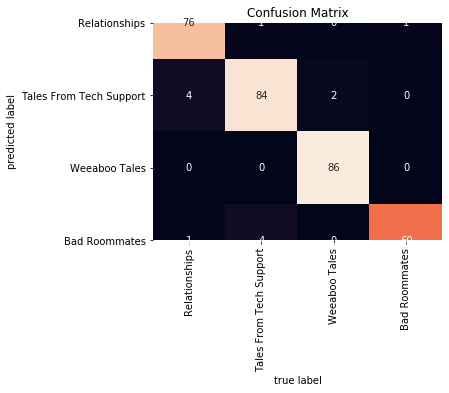

None
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
                         Error_Rate       AUC  Precision  Average_Precision  \
Category                                                                      
Tales From Tech Support    0.078370  0.880327   0.906667           0.773326   
Weeaboo Tales              0.037618  0.953483   0.884058           0.842194   
Bad Roommates              0.087774  0.876875   0.828947           0.716556   
Relationships              0.059561  0.941655   0.858586           0.826561   

                           Recall  
Category                           
Tales From Tech Support  0.790698  
Weeaboo Tales            0.938462  
Bad Roommates            0.807692  
Relationships 

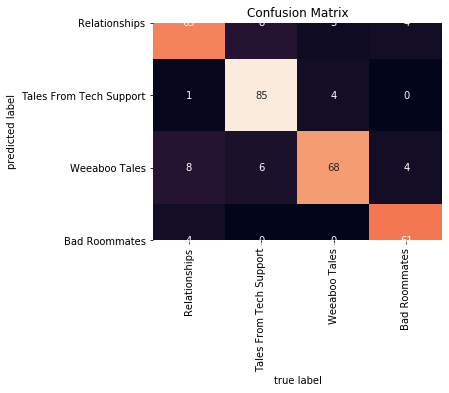

None
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
                         Error_Rate       AUC  Precision  Average_Precision  \
Category                                                                      
Tales From Tech Support    0.012539  0.980412   0.988095           0.963031   
Weeaboo Tales              0.012539  0.974955   0.984127           0.948110   
Bad Roommates              0.015674  0.980955   0.962025           0.943628   
Relationships              0.021944  0.977972   0.946237           0.931479   

                           Recall  
Category                           
Tales From Tech Suppo

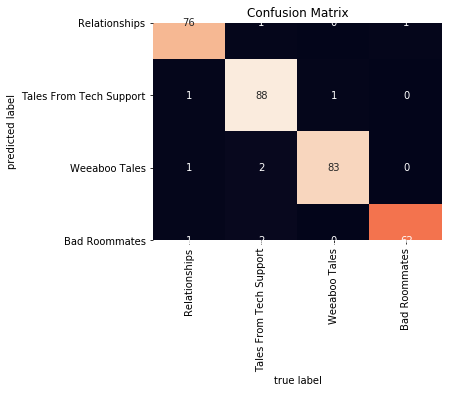

None
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
                         Error_Rate       AUC  Precision  Average_Precision  \
Category                                                                      
Tales From Tech Support    0.006270  0.992040   0.988372           0.980014   
Weeaboo Tales              0.018809  0.959570   0.983607           0.923618   
Bad Roommates              0.012539  0.983030   0.974359           0.955645   
Relationships              0.031348  0.968049   0.925

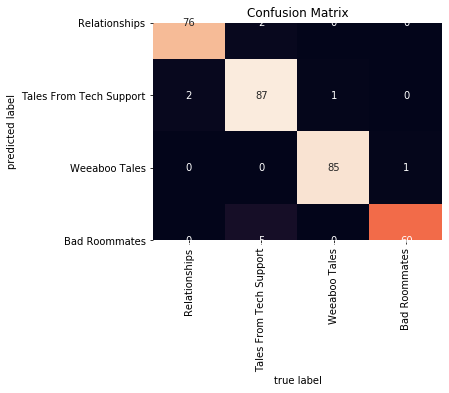

None
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
                         Error_Rate       AUC  Precision  Average_Precision  \
Category                                                                      
Tales From Tech Support    0.025078  0.968160   0.953488           0.921679   
Weeaboo Tales              0.015674  0.967262   0.983871           0.935864   
Bad Roommates              0.021944  0.968135   0.961039           0.924294   
Relationships              0.018809  0.983527   0.946809           0.93942

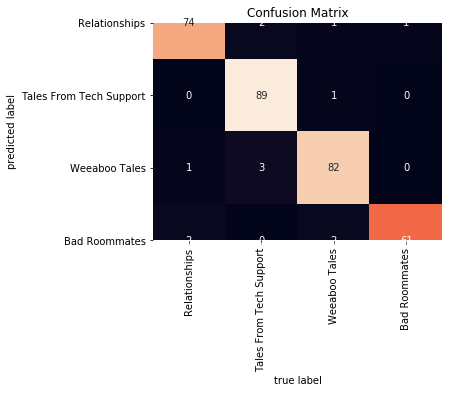

None
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [181]:
#dfTrain_reddit, dfTest_reddit
print_classifier_results(clf_bayes,dfTrain_reddit, dfTest_reddit) 
print_classifier_results(clf_linear,dfTrain_reddit, dfTest_reddit)
print_classifier_results(clf_poly,dfTrain_reddit, dfTest_reddit)
print_classifier_results(clf_kneighbors,dfTrain_reddit, dfTest_reddit) 
print_classifier_results(clf_classical,dfTrain_reddit, dfTest_reddit) # 
print_classifier_results(clf_decisiontree,dfTrain_reddit, dfTest_reddit) 
print_classifier_results(clf_randomforest,dfTrain_reddit, dfTest_reddit) #
print_classifier_results(clf_connectionist,dfTrain_reddit, dfTest_reddit) #
print_classifier_results(clf_ensemble,dfTrain_reddit, dfTest_reddit) 

                       Error_Rate       AUC  Precision  Average_Precision  \
Category                                                                    
misc.forsale             0.121277  0.815592   0.782178           0.616504   
comp.sys.mac.hardware    0.134043  0.839266   0.641667           0.551917   
comp.windows.x           0.087234  0.895486   0.837037           0.756980   
rec.autos                0.087234  0.873293   0.877193           0.748150   

                         Recall  
Category                         
misc.forsale           0.692982  
comp.sys.mac.hardware  0.793814  
comp.windows.x         0.856061  
rec.autos              0.787402  


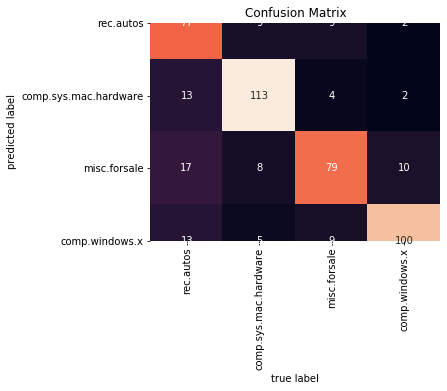

None
GaussianNB(priors=None, var_smoothing=1e-09)
                       Error_Rate       AUC  Precision  Average_Precision  \
Category                                                                    
misc.forsale             0.059574  0.909989   0.898148           0.800384   
comp.sys.mac.hardware    0.063830  0.914016   0.825243           0.748683   
comp.windows.x           0.036170  0.947149   0.960000           0.898259   
rec.autos                0.061702  0.930454   0.865672           0.814096   

                         Recall  
Category                         
misc.forsale           0.850877  
comp.sys.mac.hardware  0.876289  
comp.windows.x         0.909091  
rec.autos              0.913386  


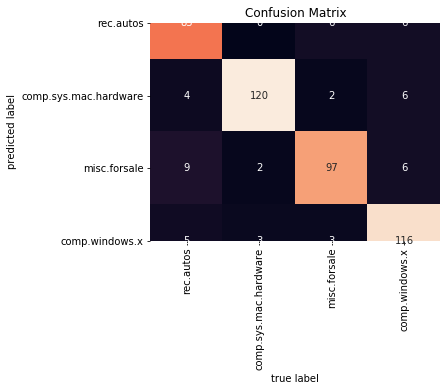

None
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
                       Error_Rate       AUC  Precision  Average_Precision  \
Category                                                                    
misc.forsale             0.068085  0.892445   0.894231           0.774185   
comp.sys.mac.hardware    0.076596  0.905973   0.779817           0.708876   
comp.windows.x           0.091489  0.844047   0.968421           0.760067   
rec.autos                0.100000  0.916611   0.746914           0.724392   

                         Recall  
Category                         
misc.forsale           0.815789  
comp.sys.mac.hardware  0.876289  
comp.windows.x         0.696970  
rec.autos              0.952756  


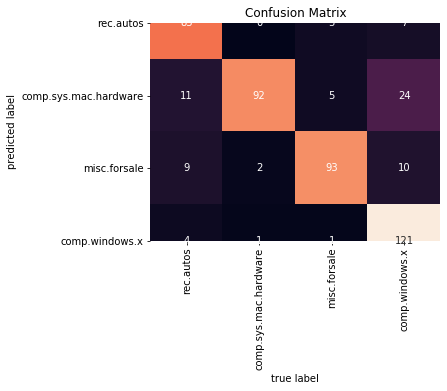

None
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
                       Error_Rate       AUC  Precision  Average_Precision  \
Category                                                                    
misc.forsale             0.257447  0.514020   0.347826           0.249941   
comp.sys.mac.hardware    0.587234  0.523230   0.217666           0.214409   
comp.windows.x           0.259574  0.537879   1.000000           0.335332   
rec.autos                0.389362  0.497704   0.266667           0.269319   

                         Recall  
Category                         
misc.forsale           0.070175  
comp.sys.mac.hardware  0.711340  
comp.windows.x         0.075758  
rec.autos              0.251969  


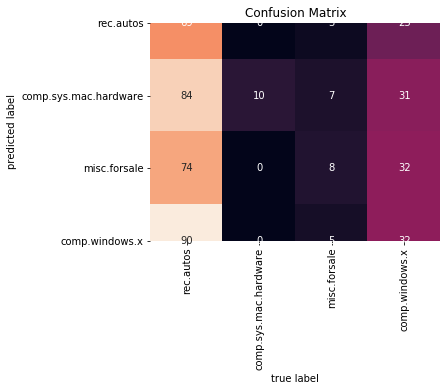

None
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')
                       Error_Rate       AUC  Precision  Average_Precision  \
Category                                                                    
misc.forsale             0.046809  0.930342   0.918182           0.841136   
comp.sys.mac.hardware    0.063830  0.910201   0.831683           0.747880   
comp.windows.x           0.027660  0.959992   0.968504           0.921619   
rec.autos                0.048936  0.944159   0.893939           0.849738   

                         Recall  
Category                         
misc.forsale           0.885965  
comp.sys.mac.hardware  0.865979  
comp.windows.x         0.931818  
rec.autos              0.929134  


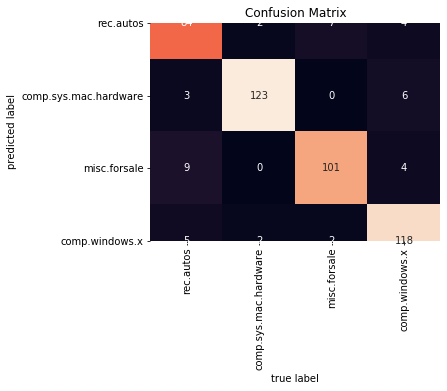

None
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
                       Error_Rate       AUC  Precision  Average_Precision  \
Category                                                                    
misc.forsale             0.125532  0.830672   0.739130           0.612808   
comp.sys.mac.hardware    0.138298  0.809886   0.648148           0.525183   
comp.windows.x           0.108511  0.852990   0.834711           0.704638   
rec.autos                0.142553  0.818037   0.738095           0.612835   

                         Recall  
Category                         
misc.forsale           0.745614  
comp.sys.mac.hardware  0.721649  
comp.windows.x         0.765152  
rec.autos              0.732283  


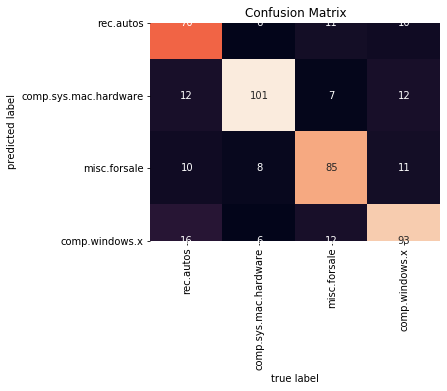

None
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
                       Error_Rate       AUC  Precision  Average_Precision  \
Category                                                                    
misc.forsale             0.057447  0.908412   0.914286           0.808223   
comp.sys.mac.hardware    0.068085  0.903706   0.821782           0.732962   
comp.windows.x           0.055319  0.929218   0.907692           0.841209   
rec.autos                0.082979  0.903480   0.828358           0.758041   

                         Recall  
Category                         
misc.forsale           0.842105  
com

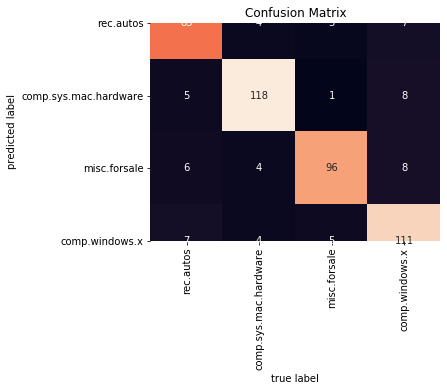

None
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
                       Error_Rate       AUC  Precision  Average_Precision  \
Category                                                                    
misc.forsale             0.057447  0.926301   0.871795           0.805559   
comp.sys.mac.hardware    0.055319  0.911749   0.873684           0.777373   
comp.windows.x           0.027660  0.957683   0.976000           0.923337   
rec.autos                0.051064  0.942701   0.887218         

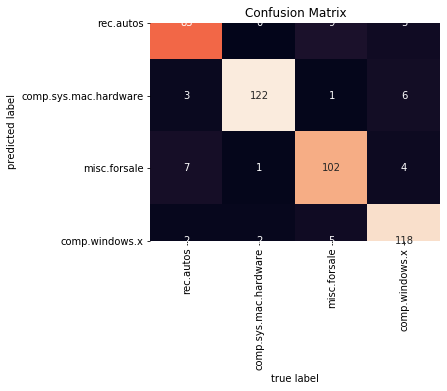

None
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
                       Error_Rate       AUC  Precision  Average_Precision  \
Category                                                                    
misc.forsale             0.078723  0.891386   0.840708           0.741016   
comp.sys.mac.hardware    0.155319  0.864003   0.580000           0.541483   
comp.windows.x           0.065957  0.905662   0.917355           0.816093   
rec.autos                0.112766  0.806214   0.930233           0.685973   

      

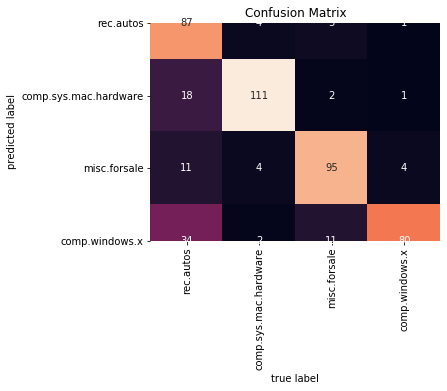

None
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [168]:
print_classifier_results(clf_bayes,dfTrain_news, dfTest_news) 
print_classifier_results(clf_linear,dfTrain_news, dfTest_news)
print_classifier_results(clf_poly,dfTrain_news, dfTest_news)
print_classifier_results(clf_kneighbors,dfTrain_news, dfTest_news) 
print_classifier_results(clf_classical,dfTrain_news, dfTest_news) #
print_classifier_results(clf_decisiontree,dfTrain_news, dfTest_news) 
print_classifier_results(clf_randomforest,dfTrain_news, dfTest_news)
print_classifier_results(clf_connectionist,dfTrain_news, dfTest_news) #2nd?
print_classifier_results(clf_ensemble,dfTrain_news, dfTest_news) 

          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
Clinton     0.170088  0.818292   0.839623           0.810247  0.881188
Obama       0.170088  0.818292   0.813953           0.714564  0.755396


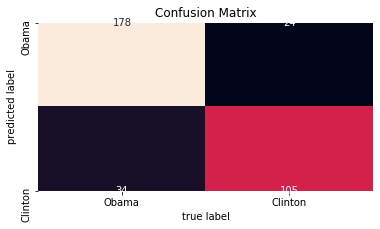

None
GaussianNB(priors=None, var_smoothing=1e-09)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
Clinton     0.002933  0.996403   0.995074           0.995074  1.000000
Obama       0.002933  0.996403   1.000000           0.995738  0.992806


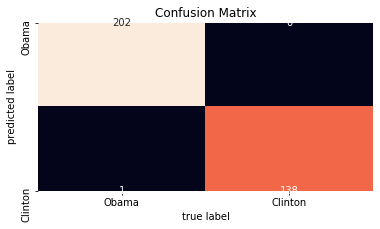

None
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
Clinton     0.129032  0.845092   0.829167           0.825650  0.985149
Obama       0.129032  0.845092   0.970297           0.804329  0.705036


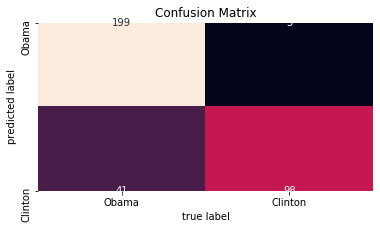

None
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
Clinton     0.102639  0.895416   0.919598           0.888820  0.905941
Obama       0.102639  0.895416   0.866197           0.813412  0.884892


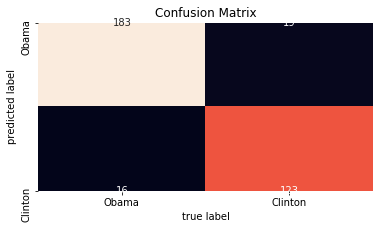

None
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
Clinton     0.026393  0.967626   0.957346           0.957346  1.000000
Obama       0.026393  0.967626   1.000000           0.961645  0.935252


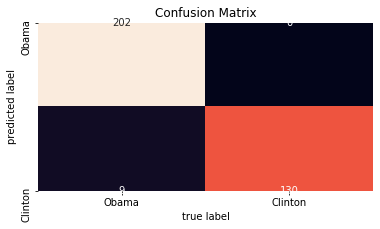

None
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
Clinton      0.01173  0.985612   0.980583           0.980583  1.000000
Obama        0.01173  0.985612   1.000000           0.982953  0.971223


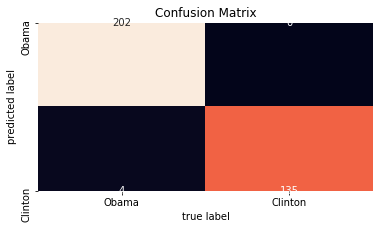

None
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
Clinton     0.005865  0.992806   0.990196           0.990196  1.000000
Obama       0.005865  0.992806   1.000000           0.991477  0.985612


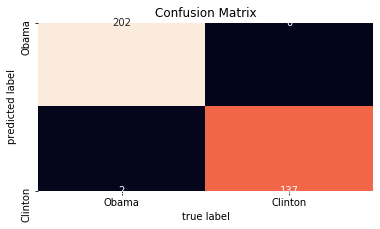

None
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
Clinton     0.046921  0.954787   0.974490           0.953682  0.945545
Obama       0.046921  0.954787   0.924138           0.905558  0.964029


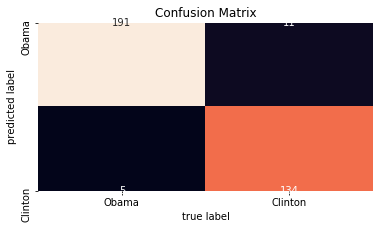

None
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
Clinton      0.01173  0.985612   0.980583           0.980583  1.000000
Obama        0.01173  0.985612   1.000000           0.982953  0.971223


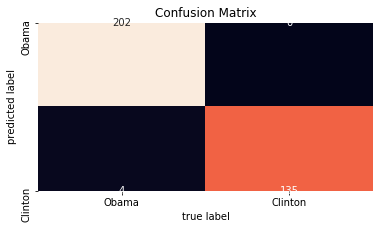

None
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [169]:
print_classifier_results(clf_bayes,dfTrain_senatesmall, dfTest_senatesmall) 
print_classifier_results(clf_linear,dfTrain_senatesmall, dfTest_senatesmall) #lowest error rate, high AUC
print_classifier_results(clf_poly,dfTrain_senatesmall, dfTest_senatesmall)
print_classifier_results(clf_kneighbors,dfTrain_senatesmall, dfTest_senatesmall) 
print_classifier_results(clf_classical,dfTrain_senatesmall, dfTest_senatesmall) 
print_classifier_results(clf_decisiontree,dfTrain_senatesmall, dfTest_senatesmall) 
print_classifier_results(clf_randomforest,dfTrain_senatesmall, dfTest_senatesmall)
print_classifier_results(clf_connectionist,dfTrain_senatesmall, dfTest_senatesmall)
print_classifier_results(clf_ensemble,dfTrain_senatesmall, dfTest_senatesmall) 

           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                               
Klobuchar    0.044872  0.745845   0.828571           0.451465  0.500000
Kohl         0.044872  0.742647   1.000000           0.530166  0.485294
Kerry        0.152564  0.767007   0.802548           0.585349  0.588785
Kennedy      0.253846  0.768516   0.642166           0.634635  0.962319
Kyl          0.078205  0.688014   0.947368           0.434644  0.378947


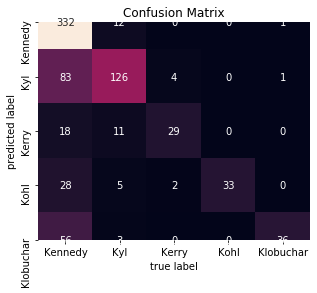

None
GaussianNB(priors=None, var_smoothing=1e-09)
           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                               
Klobuchar    0.001282  0.991379   1.000000           0.984041  0.982759
Kohl         0.003846  0.977941   1.000000           0.959729  0.955882
Kerry        0.020513  0.972788   0.966981           0.937852  0.957944
Kennedy      0.030769  0.970615   0.949580           0.940758  0.982609
Kyl          0.007692  0.968421   1.000000           0.944534  0.936842


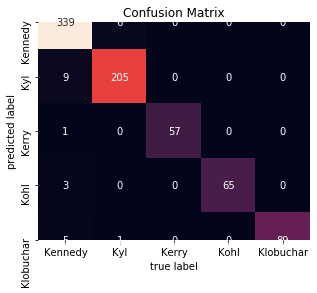

None
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                               
Klobuchar    0.038462  0.741379   1.000000           0.521220  0.482759
Kohl         0.041026  0.764706   1.000000           0.570437  0.529412
Kerry        0.141026  0.764786   0.888060           0.615622  0.556075
Kennedy      0.265385  0.760570   0.627306           0.624625  0.985507
Kyl          0.073077  0.704533   0.975000           0.472058  0.410526


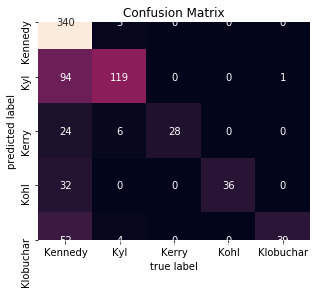

None
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                               
Klobuchar    0.030769  0.872385   0.814815           0.636084  0.758621
Kohl         0.034615  0.828073   0.918367           0.637230  0.661765
Kerry        0.155128  0.762334   0.800000           0.578936  0.579439
Kennedy      0.184615  0.829085   0.721854           0.707269  0.947826
Kyl          0.053846  0.815213   0.884058           0.611248  0.642105


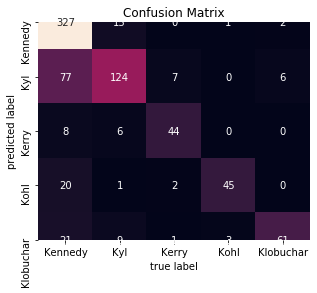

None
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')
           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                               
Klobuchar    0.003846  0.974138   1.000000           0.952122  0.948276
Kohl         0.007692  0.955882   1.000000           0.919457  0.911765
Kerry        0.020513  0.972788   0.966981           0.937852  0.957944
Kennedy      0.042308  0.960570   0.923913           0.916933  0.985507
Kyl          0.015385  0.936842   1.000000           0.889069  0.873684


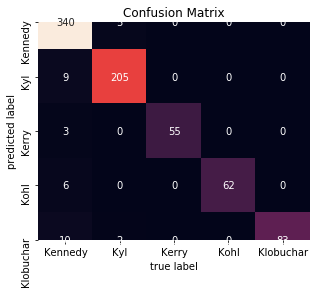

None
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                               
Klobuchar    0.003846  0.997922   0.950820           0.950820  1.000000
Kohl         0.002564  0.991945   0.985294           0.972087  0.985294
Kerry        0.000000  1.000000   1.000000           1.000000  1.000000
Kennedy      0.006410  0.993053   0.997076           0.990644  0.988406
Kyl          0.000000  1.000000   1.000000           1.000000  1.000000


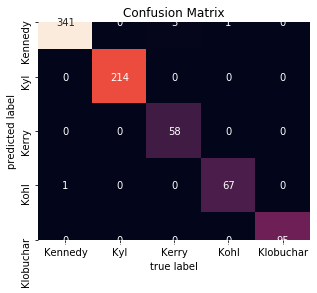

None
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                               
Klobuchar    0.001282  0.991379   1.000000           0.984041  0.982759
Kohl         0.001282  0.992647   1.000000           0.986576  0.985294
Kerry        0.002564  0.996780   0.995327           0.991958  0.995327
Kennedy      0.005128  0.995102   0.991354           0.989763  0.997101
Kyl          0.000000  1.000000   1.000000           1.000000  1.000000


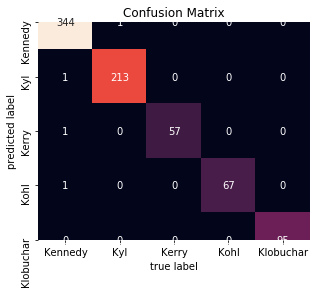

None
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                               
Klobuchar    0.006410  0.980681   0.949153           0.918987  0.965517
Kohl         0.005128  0.970588   1.000000           0.946305  0.941176
Kerry        0.044872  0.932755   0.949749           0.870848  0.883178
Kennedy      0.044872  0.957671   0.923497           0.913734  0.979710
Kyl          0.0

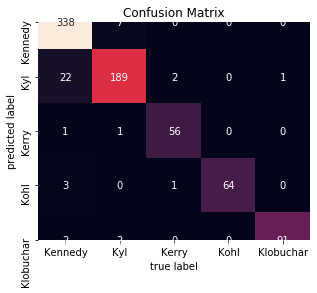

None
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                               
Klobuchar    0.000000  1.000000   1.000000           1.000000  1.000000
Kohl         0.002564  0.985294   1.000000           0.973152  0.970588
Kerry        0.000000  1.000000   1.000000           1.000000  1.000000
Kennedy      0.002564  0.997701   0.994236           0.994236  1.000000
Kyl          0.000000  1.000000   1.0

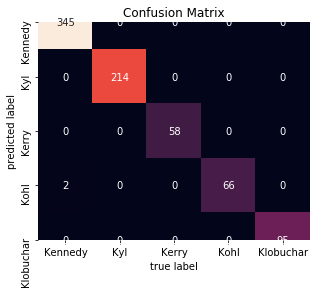

None
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [170]:
print_classifier_results(clf_bayes,dfTrain_senatelarge, dfTest_senatelarge) 
print_classifier_results(clf_linear,dfTrain_senatelarge, dfTest_senatelarge) 
print_classifier_results(clf_poly,dfTrain_senatelarge, dfTest_senatelarge)
print_classifier_results(clf_kneighbors,dfTrain_senatelarge, dfTest_senatelarge) 
print_classifier_results(clf_classical,dfTrain_senatelarge, dfTest_senatelarge) #
print_classifier_results(clf_decisiontree,dfTrain_senatelarge, dfTest_senatelarge) 
print_classifier_results(clf_randomforest,dfTrain_senatelarge, dfTest_senatelarge)
print_classifier_results(clf_connectionist,dfTrain_senatelarge, dfTest_senatelarge)
print_classifier_results(clf_ensemble,dfTrain_senatelarge, dfTest_senatelarge) #

          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
not spam    0.147661  0.809524   0.955140           0.942635  0.869048
spam        0.147661  0.809524   0.483221           0.397504  0.750000


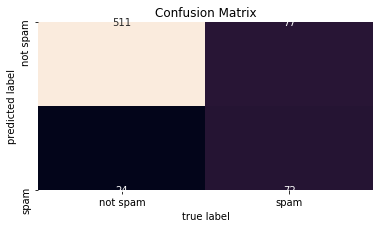

None
GaussianNB(priors=None, var_smoothing=1e-09)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
not spam    0.086257  0.736288   0.921850           0.920792  0.982993
spam        0.086257  0.736288   0.824561           0.475329  0.489583


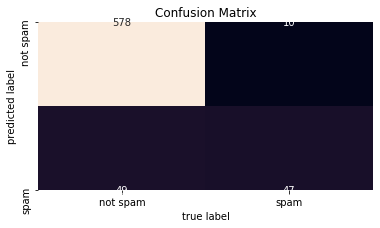

None
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
not spam    0.099415  0.663265   0.901235           0.900952  0.993197
spam        0.099415  0.663265   0.888889           0.389864  0.333333


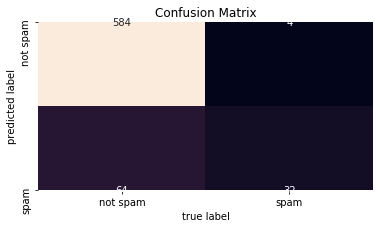

None
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
not spam    0.118421  0.674001   0.905600           0.903881  0.962585
spam        0.118421  0.674001   0.627119           0.327959  0.385417


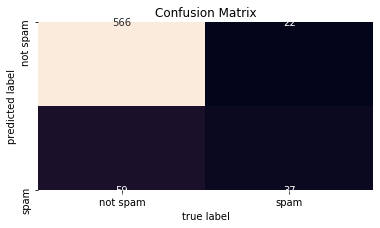

None
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
not spam    0.111111  0.608525   0.886707           0.886661  0.998299
spam        0.111111  0.608525   0.954545           0.318456  0.218750


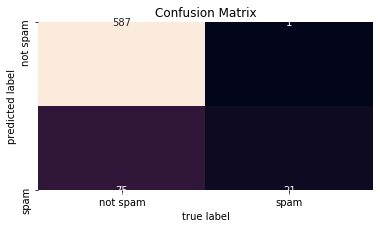

None
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
not spam    0.086257  0.784226   0.937190           0.934421  0.964286
spam        0.086257  0.784226   0.734177           0.499121  0.604167


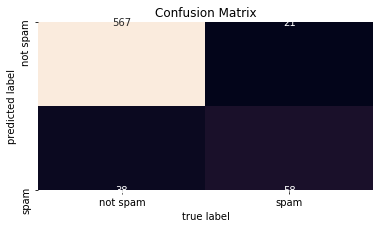

None
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
not spam    0.077485  0.771896   0.932149           0.930792  0.981293
spam        0.077485  0.771896   0.830769           0.528711  0.562500


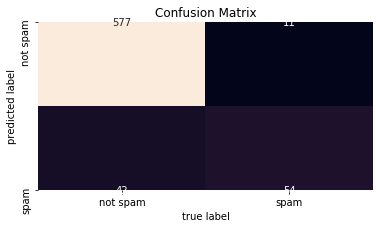

None
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
not spam    0.099415  0.767857   0.933333           0.929825  0.952381
spam        0.099415  0.767857   0.666667           0.447368  0.583333


/Users/wanxing/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


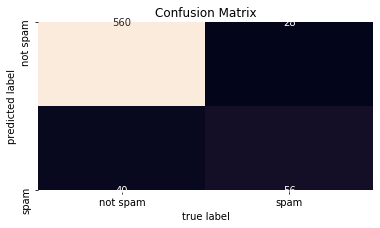

None
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
not spam    0.109649  0.622449   0.890411           0.890254  0.994898
spam        0.109649  0.622449   0.888889           0.327485  0.250000


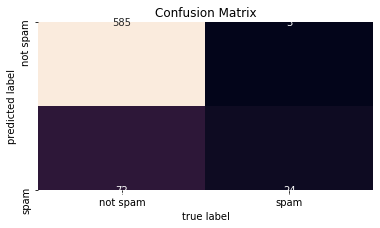

None
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [171]:
print_classifier_results(clf_bayes,dfTrain_spam, dfTest_spam) #high AUC
print_classifier_results(clf_linear,dfTrain_spam, dfTest_spam)
print_classifier_results(clf_poly,dfTrain_spam, dfTest_spam)
print_classifier_results(clf_kneighbors,dfTrain_spam, dfTest_spam) 
print_classifier_results(clf_classical,dfTrain_spam, dfTest_spam) 
print_classifier_results(clf_decisiontree,dfTrain_spam, dfTest_spam) 
print_classifier_results(clf_randomforest,dfTrain_spam, dfTest_spam) #low error
print_classifier_results(clf_connectionist,dfTrain_spam, dfTest_spam)
print_classifier_results(clf_ensemble,dfTrain_spam, dfTest_spam) 

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Go back through all of the cells above and generate 10 distinct artificial datasets and classify them with all of the available methods. Add a cell immediately below and describe which classifier(s) worked best with which artificially constructed data source and why. Then go through all of the empirical datasets (i.e., Newsgroups, Senate Small, Senate Large, Email Spam) and classify them with all available methods. Add a second cell immediately below and describe which classifier(s) worked best with which data set and why.

<span style="color:red">***Stretch*** (but also required) Wander through the SKLearn documentation available [here](http://scikit-learn.org/stable/), particularly perusing the classifiers. In cells following, identify and implement a new classifier that we have not yet used (e.g., AdaBoost, CART) on one artificial dataset and one real dataset (used above). Then, in the next cell describe the classifier, detail how it compares with the approaches above, and why it performed better or worse than others.

## Artificial datasets
I have generated 10 artificial datasets in the cells above, with 5 different forms of datasets at noise =0.3, and another set of 5 datasets at noise = 0.5, each classified with the 9 available methods. I've also chosen to generate confusion matrices for each pairing of dataset and classification method. To evaluate how each classifier works with each dataset, I'm mainly focusing on how low the error rate is and how high the AUC is.

According to the results, a Gaussian Naive Bayes classifier works the best with the dataset that is linearly split along one of two dimensions at noise =0.5, the dataset in which one class is nested with the other in two dimensions at noise 0.5, and the dataset in which 5 classes are placed as bivariate Guassians randomly at noise 0.5, as it produces the lowest error rate values and higher AUC for these two datasets compared to other methods.

A linear SVC works the best with the dataset linearly split among 2 classes, with noise = 0.5, as it is one of the methods that produce the lowest error rates for this dataset. It also works the best for the dataset that is linearly split along one of two dimensions at the higher noise level at 0.5, also due to its lower error rate and higher AUC rate compared to other methods.

The poly SVC performs the best at the seventh dataset, in which two classes are linearly split with noise level at 0.5, and its error rate is the same as the linear SVC here.

The k neighbors SVC works relatively the best with the dataset generated with oppositely split variables at noise =0.3 as this method has the second lowest error for this dataset compared to other methods.

The classicial logistic regression classifier works the best with the dataset generated with classes linearly split among 2 dimensions at noise =0.3, as it is one of the methods that produce the same lowest error rate and high AUC for this dataset. It also performs the best for the multiBlobs dataset of 5 bivariate Guassian classes at noise level 0.5

The decision tree classifier works the best with the dataset that is randomly generated among two classes with noise level of 0.3, as it is the method that produces the lowest error rate and highest AUC for this dataset.

The random forest classifier relatively works the best with the dataset that is generated for oppositely split classes at noise of 0.3, as it produces relatively low error rate compared to other methods while not the lowest error.

The connectionist neural network MLP classifier works well with several different artificial datasets. It produces the lowest error rate values and high AUC values for the dataset linearly split among 2 classes at noise level 0.3, dataset of oppositely split classes among 2 dimensions at noise level 0.3, target split dataset in which one clases is nested with the other at noise level 0.3, and dataset of oppositely split classes among 2 dimensions at noise level 0.5

The ensemble gradient boosting classifier works the best with the dataset with two randomly distributed classes at noise level 0.3, with the same lowest error rate as the decision tree classifier.



## Empirical datasets

The Reddit dataset works the best with classical logistic regression method, random forest classifier, and neural network MLP classifier. While each classifier has higher error rate in some of the classes or lower AUC in some of the classes, in general all three classifiers produce results with low error rates and high AUC values distributed across the classes.

The newsgroup dataset works the best with classical logistic regression method and neural network MLP classifier, as these two methods both give low error rates and high AUC values across the 4 classes.

The Senate Small dataset works the best with the linear SVC classifier, as this method also offers the lowest error rate and a high AUC across the two classes, Obama and Clinton.

The Senate Large dataset works the best with the gradient boosting ensemble classifier, which offers the lowest error rates across categories, with 3 of 5 classes having an error rate of 0. It also also has very high AUC across 5 classes,  with 3 AUC values being 1.

The spam dataset works the best with both the Naive Bayes classifier and the random forest classifier. The Naive Bayes classifier provides the highest AUC values across the two classes, whereas the random forest classifier provides the lowest error rates across the two classes.


randomly distributed along two dimensions, noise =0.3
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.485  0.515014       0.50           0.492732  0.515464
1              0.485  0.515014       0.53           0.522718  0.514563


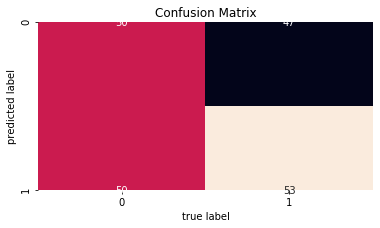

None
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
newsgroup data
                       Error_Rate       AUC  Precision  Average_Precision  \
Category                                                                    
misc.forsale             0.108511  0.827001   0.824742           0.651107   
comp.sys.mac.hardware    0.142553  0.776692   0.659574           0.496052   
comp.windows.x           0.093617  0.863345   0.885965           0.743855   
rec.autos                0.165957  0.836712   0.648485           0.588914   

                         Recall  
Category                         
misc.forsale           0.701754  
comp.sys.mac.hardware  0.639175  
comp.windows.x         0.765152  
rec.autos              0.842520  


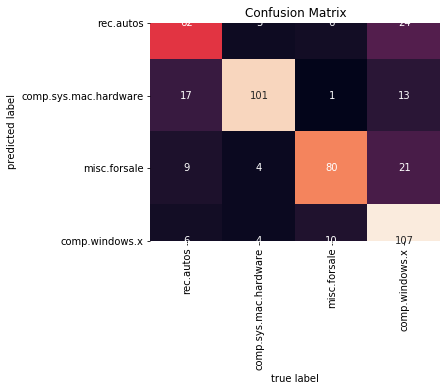

None
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)


In [182]:
## Using Adaboost classifier, with the artificial dataset 1 and the newsgroup data

clf_adaboost = sklearn.ensemble.AdaBoostClassifier()
print('randomly distributed along two dimensions, noise =0.3')
print_classifier_results(clf_adaboost,dfTrain1, dfTest1)
print('newsgroup data')
print_classifier_results(clf_adaboost,dfTrain_news, dfTest_news)


I have selected the Adaboost classifier for this exercise, which is an ensemble classifier that applies a series weak learners on the training data samples through adjusting the weights of each learner in the algorithm, combine the results and produce the final prediction through a weighted majority vote. 

The result of applying the AdaBoost classifier on a dataset 1, a dataset with values randomly distributed along two dimensions at a noise level 0.3, is that it is performed better than all other classifiers. Its error rate 0.485 is lower than the the error rates of all other classifiers for this dataset, the lowest of which is 0.505. The AUC values (0.515 and 0.515) it has produced are also larger than those by other classifiers, which all produce AUC values under 0.50 for this dataset.

The results for applying the AdaBoost classifier on Newsgroup dataset are not as satisfying. It has only performed better than the k neighbors classifier in terms of having lower error rates and higher AUC among all classes, and it performs about the same with the decision tree classifier and Gaussian NB classifier with about the same error rate values and AUC values, though better at some classes and worse than some others. It is however worse than the linear SVC, Poly SVC, the classical logistic regression, random forest classifier, neural network MLP classifier, and the gradient boosting classifier, all of which have higher AUC values and lower error rates. This drastic difference in performance relative to other classifiers might be due to the fact that the AdaBoost classifier uses a majority vote among a sequence of weak learners, which might cause it to be better at predicting random data than data with underlying patterns.

# Clinton / Obama Press Releases

We often will not have nicely prepared data, so we will work though the proccess of cleaning and structuring in more detail here:

While the Clinton and Obama Senatorial Press Releases are not hand-coded, we can imagine that we have been given a stack of such press releases, but lost the metadata associated with which senatorial office issued which. If we label a few of them, how well can our classifier do at recovering the rest? 

In [12]:
ObamaClintonReleases = pandas.read_csv('../data/ObamaClintonReleases.csv', index_col=0)

Let's turn the 'targetSenator' column into a binary category variable.

In [13]:
ObamaClintonReleases['category'] = [s == 'Obama' for s in ObamaClintonReleases['targetSenator']]

Tokenize and normalize

In [16]:
ObamaClintonReleases['tokenized_text'] = ObamaClintonReleases['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
ObamaClintonReleases['normalized_text'] = ObamaClintonReleases['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

Let's split the data into training data and testing data.

In [17]:
holdBackFraction = .2
train_data_df, test_data_df = lucem_illud_2020.trainTestSplit(ObamaClintonReleases, holdBackFraction=holdBackFraction)

In [18]:
print(len(train_data_df))
print(len(test_data_df))

1368
341


## Logistic Regression

First, let's try with a logistic regression, which may be familiar to you from statistical methods classes. First, we must turn the training dataset into a tf-idf matrix (`lucem_illud_2020.generateVecs()` will help with this but for now we are doing it the long way):

In [21]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['text'])

Note that we can use the CountVectorizer instead, which simply produces a matrix of word counts.

In [22]:
TFVects.shape

(1368, 11315)

We can save this in the dataframe to make things easier

In [23]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

In a regression, we cannot have more variables than cases. So, we need to first do a dimension reduction. First, we will approah this with PCA. You have previously seen this in week 3. Here we are not concerned about visualization, but rather classification and so all principal components are calculated. Watch out: we have to use `stack` not `sum` for combining the vectors. We note that you could also use topic loading and embedding dimensions as featured variables.

In [24]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

We can store the PCA space vectors in the dataframe too:

In [25]:
train_data_df['pca'] = [r for r in reduced_data]

Visualization in 2D:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


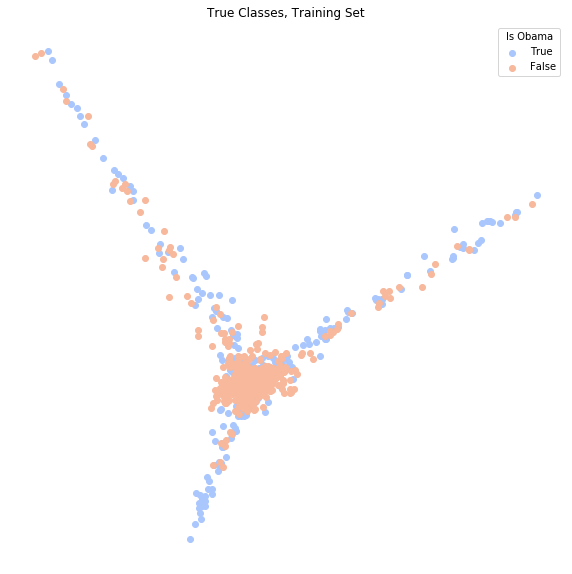

In [26]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Obama
a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not Obama
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")
    
ax.legend(loc = 'upper right', title = 'Is Obama')
plt.title('True Classes, Training Set')
plt.show()

PCA cannot distinguish Obama very well. Let's perform a screeplot to see how many Principal Components we need.

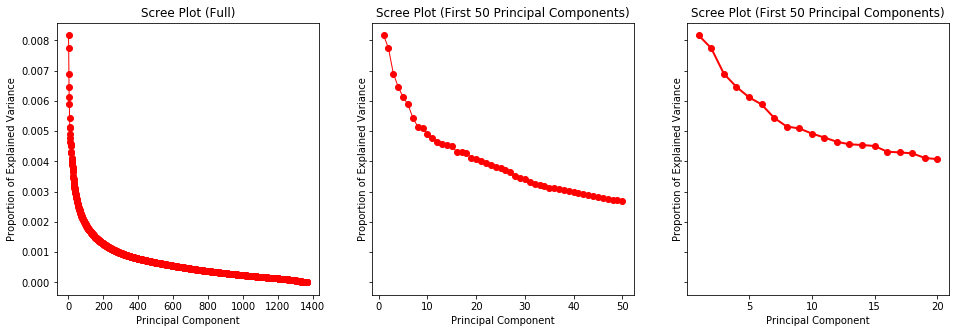

In [27]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

Let's choose the first 10 pricipal components as our covariates.

In [28]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

Now we fit a logistic regression to our data.

In [29]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Let's see how the logistic regression performs on the training dataset from which we develop the model. Unfortunately, the mean accuracy is only about 64%.

In [30]:
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

0.679093567251462

How does it perform on the testing dataset, which we "held out" and did not use for model training? We need to repeat all the steps on the testing data, but without retraining:

In [31]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])

0.6979472140762464

Slightly poorer. How about using more dimensions (40)?

In [32]:
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['category']))

Training:
0.7339181286549707
Testing:
0.7243401759530792


Or still more (100)?

In [33]:
train_data_df['pca_reduced_100'] = train_data_df['pca'].apply(lambda x: x[:100])
test_data_df['pca_reduced_100'] = test_data_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_100'], axis=0), test_data_df['category']))

Training:
0.8135964912280702
Testing:
0.7888563049853372


Or even more (200)!

In [34]:
train_data_df['pca_reduced_200'] = train_data_df['pca'].apply(lambda x: x[:200])
test_data_df['pca_reduced_200'] = test_data_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_200'], axis=0), test_data_df['category']))

Training:
0.8647660818713451
Testing:
0.8328445747800587


This is becoming ridiculous (400)!

In [35]:
train_data_df['pca_reduced_400'] = train_data_df['pca'].apply(lambda x: x[:400])
test_data_df['pca_reduced_400'] = test_data_df['pca'].apply(lambda x: x[:400])

logistic.fit(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_400'], axis=0), test_data_df['category']))

Training:
0.9137426900584795
Testing:
0.841642228739003


Increasing the number of covariates would overfit our data, and it seems that using a logistic regression, our prediction accuracy is at best about 65%. We can, however, try a logistic regression that uses the TF-IDF scores for each word, but with an L1 regularization or L1-norm loss function, which is also known as least absolute deviations (LAD), least absolute errors (LAE) or L1 penalty. It minimizes the sum of the absolute differences (S) between the target value ($Y_i$) and the estimated values ($f(x_i)$) and prunes all insignificant variables (i.e., word TF-IDF scores):

$S=\sum^n_{i=1}|y_i=f(x_i)|$

The result is a model retaining only the most individually significant features.

In [36]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l2')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))

0.9641812865497076


Train the model using training data, and then test it on the testing data.

In [37]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

0.8563049853372434


81% accuracy seems like the best we can get by using a logistic regression.

Now let's try with Naive Bayes. Classically, it is trained with word counts, but TF-IDF vectors are also quite good:

In [38]:
naiveBayes = sklearn.naive_bayes.BernoulliNB()
naiveBayes.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [39]:
print("Training:")
print(naiveBayes.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))
print("Testing:")
print(naiveBayes.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

Training:
0.9605263157894737
Testing:
0.8944281524926686


A bit better than the logit, but that's just looking at the accuracy. What about other measures? Let's first save the predictions in the dataframe to save use rerunning the model every time:

In [40]:
test_data_df['nb_predict'] = naiveBayes.predict(np.stack(test_data_df['vect'], axis=0))
test_data_df['nb_predict_prob_true'] = naiveBayes.predict_proba(np.stack(test_data_df['vect'], axis=0))[:,0] #other is prop false

Precision:

In [41]:
sklearn.metrics.precision_score(test_data_df['category'], test_data_df['nb_predict'])

0.905511811023622

Recall:

In [42]:
sklearn.metrics.recall_score(test_data_df['category'], test_data_df['nb_predict'])

0.8273381294964028

F1-measure:

In [43]:
sklearn.metrics.f1_score(test_data_df['category'], test_data_df['nb_predict'])

0.8646616541353382

Let's take a look at how well our posterior distribution looks relative to the truth.

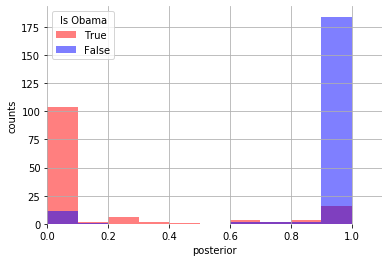

In [44]:
fig, ax = plt.subplots()
ax.grid(False)
ax.set_frame_on(False)
test_data_df[test_data_df['category'].eq(True)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'True', color = 'red')
test_data_df[test_data_df['category'].eq(False)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'False', color = 'blue')
ax.set_xlim((0,1.1))
ax.legend(title = "Is Obama")
ax.set_xlabel('posterior')
ax.set_ylabel('counts')
plt.show()

The classification is suprisingly accurate. We can even look at what words are most influential with a bit of simple math:

In [45]:
#Top indices
trueVals, falseVals = naiveBayes.feature_log_prob_

words_dict = {
    'Obama' : [],
    'Obama_log_prob' : [],
    'Clinton' : [],
    'Clinton_log_prob' : [],
}

for i, prob in sorted(enumerate(trueVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Obama'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Obama_log_prob'].append(prob)

for i, prob in sorted(enumerate(falseVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Clinton'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Clinton_log_prob'].append(prob)
    
pandas.DataFrame(words_dict)

,Obama,Obama_log_prob,Clinton,Clinton_log_prob
0,yorkers,-2.069491,amy,-1.795262
1,signature,-2.173752,brundage,-1.871802
2,welcomed,-2.195975,dick,-1.894792
3,awarded,-2.340806,chicago,-2.031651
4,fy,-2.353878,temporary,-2.159484
5,ground,-2.367124,interests,-2.238265
6,urging,-2.380547,location,-2.238265
7,read,-2.450505,reform,-2.238265
8,urged,-2.450505,political,-2.271602
9,welcome,-2.450505,reported,-2.306088


## Multinomial Naive Bayes

What if we want to classify our text into one of *many* classes? The multinomial Naive Bayes generating model assumes that document features (e.g., words) are generated by draws from a multinomial distribution (recall this gives the probability to observe a particular pattern of counts across features). 

Let's use again the dataset we used in week 3, the 20 newsgroup dataset.

In [55]:
newsgroups = sklearn.datasets.fetch_20newsgroups(data_home = '../data') #Free data to play with: documents from a newsgroup corpus.
newsgroups.target_names #Possible categories, i.e., the newsgroups

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

We can pick specific categories, and pull the relevant training and testing sets. 

In [56]:
target_categories = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics'] #Can change these of course

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])
for category in target_categories:
    print("Loading data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

Loading data for: talk.religion.misc
Loading data for: soc.religion.christian
Loading data for: sci.space
Loading data for: comp.graphics


Now we need to tokenize, and make a training and testing set:

In [57]:
newsgroupsDF['tokenized_text'] = newsgroupsDF['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
newsgroupsDF['normalized_text'] = newsgroupsDF['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

In [66]:
holdBackFraction = .2
train_ng_df, test_ng_df = lucem_illud_2020.trainTestSplit(newsgroupsDF, holdBackFraction=holdBackFraction)

In [67]:
print(len(train_ng_df))
print(len(test_ng_df))

1723
430


We need to extract features from the text. We can use built-in feature extraction to do so. We will use a tf-idf vectorizer, which converts the document into a vector of words with tf-idf weights (term-frequency inverse-document frequency). This gives high weight to words that show up a lot in a given document, but rarely across documents in the corpus (more distinctive). 

In [68]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

Now we can train the model:

In [69]:
MultinomialNB_ng = sklearn.naive_bayes.MultinomialNB()
MultinomialNB_ng.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

...and save predictions to the dataframe:

In [70]:
train_ng_df['nb_predict'] = MultinomialNB_ng.predict(np.stack(train_ng_df['vect'], axis=0))
print("Training score:")
print(MultinomialNB_ng.score(np.stack(train_ng_df['vect'], axis=0), train_ng_df['category']))

Training score:
0.8984329657573998


In [71]:
train_ng_df[['category', 'nb_predict']][:10]

,category,nb_predict
1794,comp.graphics,comp.graphics
451,soc.religion.christian,soc.religion.christian
1272,sci.space,sci.space
1953,comp.graphics,sci.space
1580,comp.graphics,comp.graphics
132,talk.religion.misc,soc.religion.christian
53,talk.religion.misc,talk.religion.misc
11,talk.religion.misc,soc.religion.christian
1604,comp.graphics,comp.graphics
16,talk.religion.misc,talk.religion.misc


Looks pretty good, lets examine the testing dataset:

In [72]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = MultinomialNB_ng.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(MultinomialNB_ng.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Testing score:
0.8116279069767441


We can even use a confusion matrix, like we used last week for evaluating human coders relative to one another. Now we are evaluating our classifier relative to human coding. We'll just use the one in `lucem_illud_2020`, which requres a classifier and a dataframe with `'vect'` and `'category'` columns, like we have in the examples:

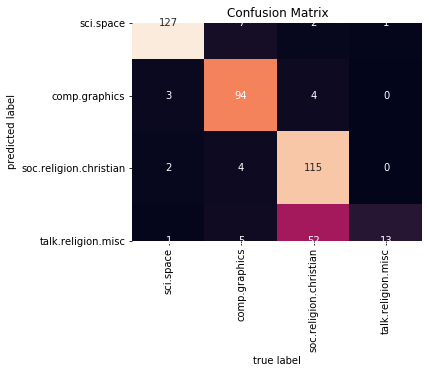

In [73]:
lucem_illud_2020.plotConfusionMatrix(MultinomialNB_ng, test_ng_df)

Let's calculate the precision, recall, and F-measures.

In [76]:
print(sklearn.metrics.precision_score(test_ng_df['category'], test_ng_df['nb_predict'], average = 'weighted')) #precision
print(sklearn.metrics.recall_score(test_ng_df['category'], test_ng_df['nb_predict'], average = 'weighted')) #recall
print(sklearn.metrics.f1_score(test_ng_df['category'], test_ng_df['nb_predict'], average = 'weighted')) #F-1 measure

0.845327295863729
0.8116279069767441
0.7796500321230174


We can evaluate these per catagory. This has the same requiments as `plotConfusionMatrix`:

In [77]:
lucem_illud_2020.metrics.evaluateClassifier(MultinomialNB_ng, test_ng_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
sci.space,0.053488,0.941030,0.854545,0.811599,0.930693
soc.religion.christian,0.148837,0.881355,0.664740,0.645731,0.950413
talk.religion.misc,0.137209,0.590157,0.928571,0.304904,0.183099
comp.graphics,0.037209,0.953265,0.954887,0.908443,0.927007


We can also plot the ROC curves. This has the same requiments as `plotConfusionMatrix`:

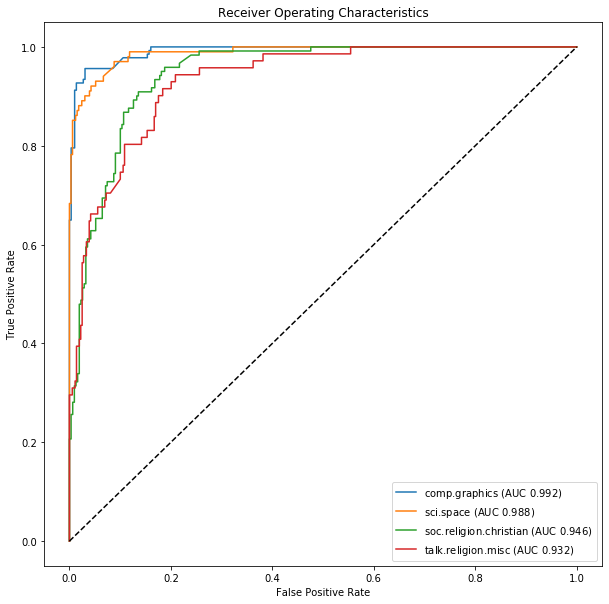

In [78]:
lucem_illud_2020.plotMultiROC(MultinomialNB_ng, test_ng_df)

And we can plot the PCA space visualization:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

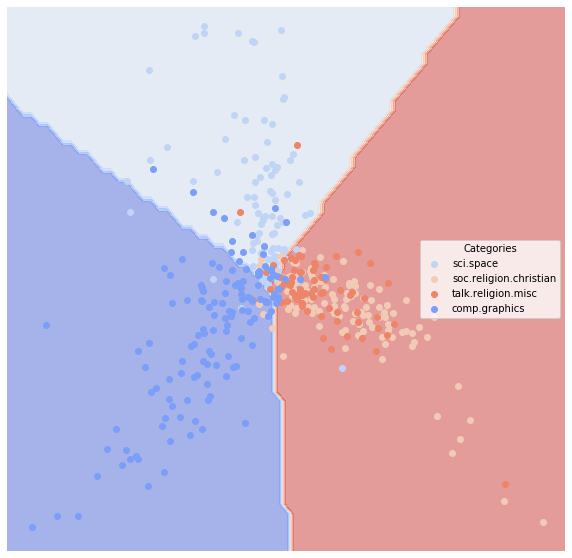

In [79]:
lucem_illud_2020.plotregions(MultinomialNB_ng, test_ng_df)

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">In the cells immediately following, perform Logistic and Naïve Bayes classification (binary or multinomial) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project (e.g., these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week). Visualize the confusion matrix for training and testing sets. Calculate precision, recall, the F-measure, and AUC, then perform an ROC visualization. How do these classifiers perform? Exrapolate codes from these models to all uncoded data.


In [209]:
#a dataset of tweets related to political sentimental analysis
df_sentiments = pandas.read_csv('Sentiment.csv')
df_sentiments = sentiments[['text','sentiment']]
#dividing sentiments into positive and non-positive
df_sentiments['category'] = [s == 'Positive' for s in df_sentiments['sentiment']]

In [198]:
df_sentiments['tokenized_text'] = df_sentiments['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
df_sentiments['normalized_text'] = df_sentiments['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))


,text,sentiment,tokenized_text,normalized_text,category
0,RT @NancyLeeGrahn: How did everyone feel about...,Neutral,"[RT, @NancyLeeGrahn, How, did, everyone, feel,...","[rt, @nancyleegrahn, feel, climate, change, qu...",Neutral
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive,"[RT, @ScottWalker, Did, n't, catch, the, full,...","[rt, @scottwalker, catch, gopdebate, night, sc...",Positive
2,RT @TJMShow: No mention of Tamir Rice and the ...,Neutral,"[RT, @TJMShow, No, mention, of, Tamir, Rice, a...","[rt, @tjmshow, mention, tamir, rice, gopdebate...",Neutral
3,RT @RobGeorge: That Carly Fiorina is trending ...,Positive,"[RT, @RobGeorge, That, Carly, Fiorina, is, tre...","[rt, @robgeorge, carly, fiorina, trend, hour, ...",Positive
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive,"[RT, @DanScavino, GOPDebate, w/, @realDonaldTr...","[rt, @danscavino, gopdebate, w/, @realdonaldtr...",Positive


In [226]:
#divide train and test data
holdBackFraction= .2
train_sentiment, test_sentiment = lucem_illud_2020.trainTestSplit(df_sentiments, holdBackFraction=holdBackFraction)

#save word vectors in training dataset 
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_sentiment['text'])
print(TFVects.shape)
train_sentiment['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

#PCA
pca = sklearn.decomposition.PCA()
sentiment_reduced_data = pca.fit_transform(np.stack(train_sentiment['vect'], axis=0))
train_sentiment['pca'] = [r for r in sentiment_reduced_data]
#choose the first 5 principal components
train_sentiment['pca_5'] = train_sentiment['pca'].apply(lambda x: x[:5])


#vectors in testing dataset 
testVects = TFVectorizer.fit_transform(test_sentiment['text'])
test_sentiment['vect'] = [np.array(v).flatten() for v in testVects.todense()]

test_sentiment_reduced = pca.fit_transform(np.stack(test_sentiment['vect'], axis=0))
test_sentiment['pca'] = [r for r in test_sentiment_reduced]
test_sentiment['pca_5'] = test_sentiment['pca'].apply(lambda x: x[:5])

logistic_l2 = sklearn.linear_model.LogisticRegression(penalty='l2')
logistic_l2.fit(np.stack(train_sentiment['pca_5'], axis=0), train_sentiment['category'])
print("training set score for sentiment data:")
print(logistic_l2.score(np.stack(train_sentiment['pca_5'], axis=0), train_sentiment['category']))

print("testing set score for sentiment data:")
print(logistic_l2.score(np.stack(test_sentiment['pca_5'], axis=0), test_sentiment['category']))
      

(11097, 5972)
training set score for sentiment data:
0.8457240695683518
testing set score for sentiment data:
0.8298485940879596


In [229]:
train_sentiment['vect'] = train_sentiment['pca_5']
test_sentiment['vect'] = test_sentiment['pca_5']

Precision Score
0.03009259259259259
Recall Score
0.19696969696969696
F measure
0.05220883534136546
AUC score
21.5
Accuracy score
0.8298485940879596
evaluate classifier
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
False       0.170151  0.503731   0.845273           0.845251  0.977370
True        0.170151  0.503731   0.196970           0.156973  0.030093


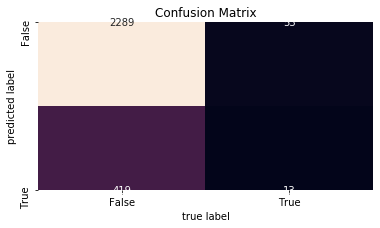

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


None


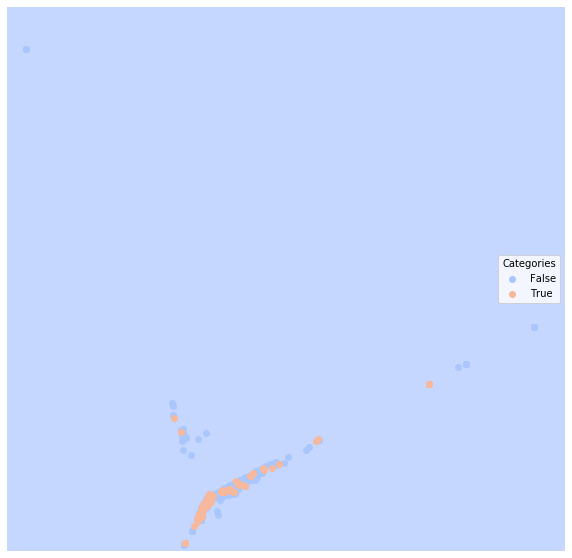

None


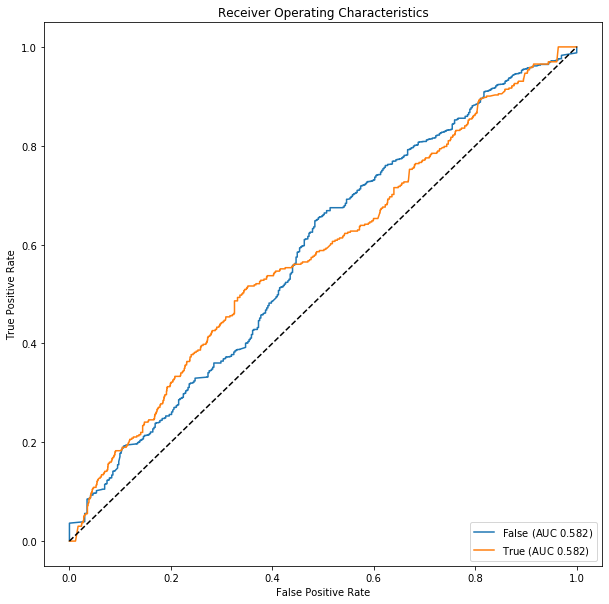

None


In [230]:
#Logistic testing
test_sentiment['logic_predict'] = logistic_l2.predict(np.stack(test_sentiment['vect'], axis=0))
print('Precision Score')
print(sklearn.metrics.precision_score(test_sentiment['logic_predict'], test_sentiment['category']))
print('Recall Score')
print(sklearn.metrics.recall_score(test_sentiment['logic_predict'], test_sentiment['category']))
print('F measure')
print(sklearn.metrics.f1_score(test_sentiment['logic_predict'], test_sentiment['category']))
print('AUC score')
print(sklearn.metrics.auc(test_sentiment['logic_predict'], test_sentiment['category']))    

print('Accuracy score')
print(logistic_l2.score(np.stack(test_sentiment['vect'], axis=0), test_sentiment['category']))
print('evaluate classifier')
print(lucem_illud_2020.evaluateClassifier(logistic_l2,test_sentiment))
print(lucem_illud_2020.plotConfusionMatrix(logistic_l2, test_sentiment))
print(lucem_illud_2020.plotregions(logistic_l2, test_sentiment))
print(lucem_illud_2020.plotMultiROC(logistic_l2, test_sentiment))

      

Training data set
0.8374335405965576
Testing data set
0.8442682047584715
Precision Score
0.0
Recall Score
0.0
F measure
0.0
AUC score
0.0
Accuracy score
0.8442682047584715
evaluate classifier
          Error_Rate  AUC  Precision  Average_Precision  Recall
Category                                                       
False       0.155732  0.5   0.844268           0.844268     1.0
True        0.155732  0.5   0.000000           0.155732     0.0


/Users/wanxing/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wanxing/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


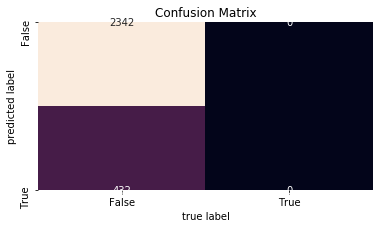

None


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


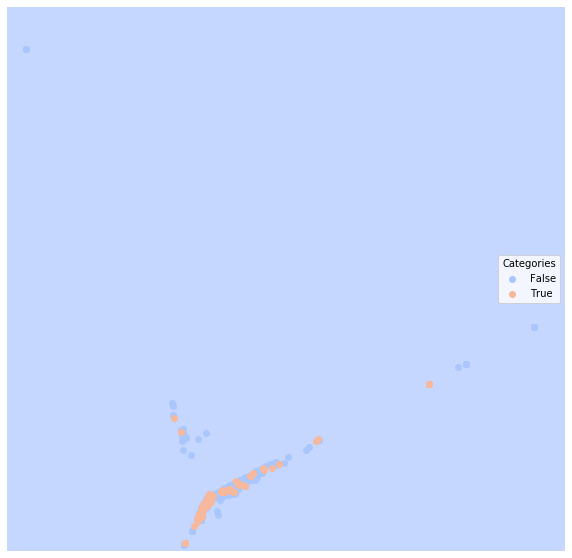

None


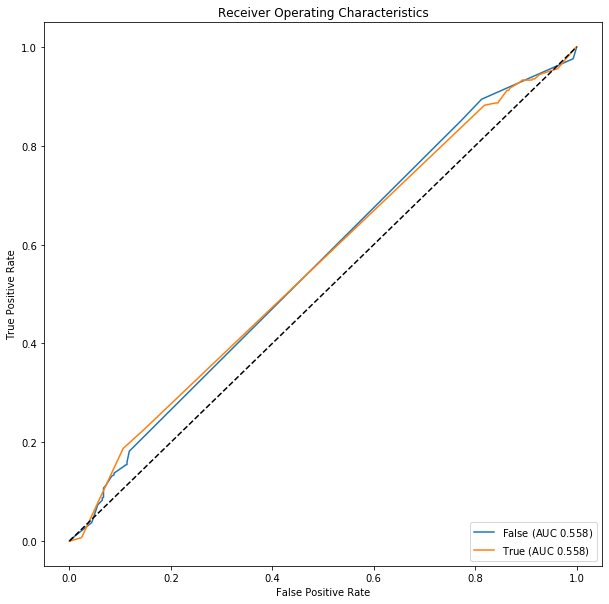

None


In [231]:
#Naive Bayes

NB= sklearn.naive_bayes.BernoulliNB()
NB.fit(np.stack(train_sentiment['vect'], axis=0), train_sentiment['category'])
print('Training data set')
print(NB.score(np.stack(train_sentiment['pca_5'], axis=0), train_sentiment['category']))
print('Testing data set')
print(NB.score(np.stack(test_sentiment['pca_5'], axis=0), test_sentiment['category']))

test_sentiment['NB_predict'] = NB.predict(np.stack(test_sentiment['vect'], axis=0))
print('Precision Score')
print(sklearn.metrics.precision_score(test_sentiment['NB_predict'], test_sentiment['category']))
print('Recall Score')
print(sklearn.metrics.recall_score(test_sentiment['NB_predict'], test_sentiment['category']))
print('F measure')
print(sklearn.metrics.f1_score(test_sentiment['NB_predict'], test_sentiment['category']))
print('AUC score')
print(sklearn.metrics.auc(test_sentiment['NB_predict'], test_sentiment['category']))    

print('Accuracy score')
print(NB.score(np.stack(test_sentiment['vect'], axis=0), test_sentiment['category']))
print('evaluate classifier')
print(lucem_illud_2020.evaluateClassifier(NB,test_sentiment))
print(lucem_illud_2020.plotConfusionMatrix(NB, test_sentiment))
print(lucem_illud_2020.plotregions(NB, test_sentiment))
print(lucem_illud_2020.plotMultiROC(NB, test_sentiment))



The results for my logistic regression and Naive Bayes model show that, while both have relatively low error rates and high accuracy scores, both also have low precision scores and relatively low AUC. The visualizations also show that while both methods perform relatively well in predicting, the accuracy isn't very high and there is a lot of room for error. While the logistical regression produces high error rates and lower accuracy score than the Naive Bayes classification, it also has higher AUC values. 

# Decision Trees

Decision trees can be used to predict both categorical/class labels (i.e., classification) and continuous labels (i.e., regression).

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

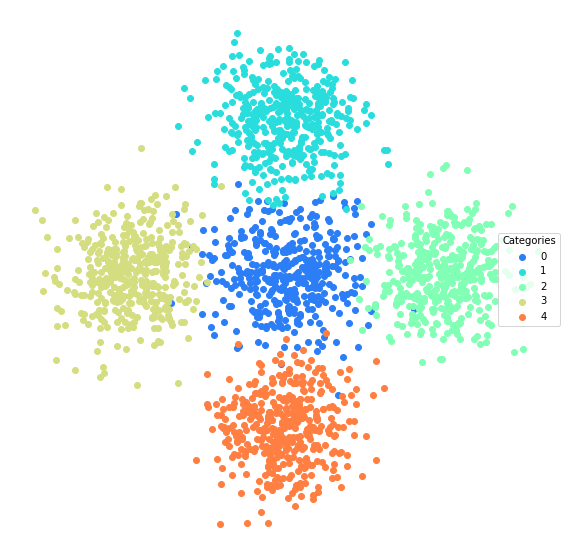

In [80]:
blobs_df = lucem_illud_2020.multiBlobs(noise=.2, centers=[(0,0), (0,5), (5,0), (-5,0), (0,-5)])
df_exampleTree_train, df_exampleTree_test = lucem_illud_2020.trainTestSplit(blobs_df)
lucem_illud_2020.plotter(df_exampleTree_train)

Now we import our Decision Tree classifier from sklearn.tree (familiar syntax) and fit it using the fit method.

In [81]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

To see what's going on visually with the classification: 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

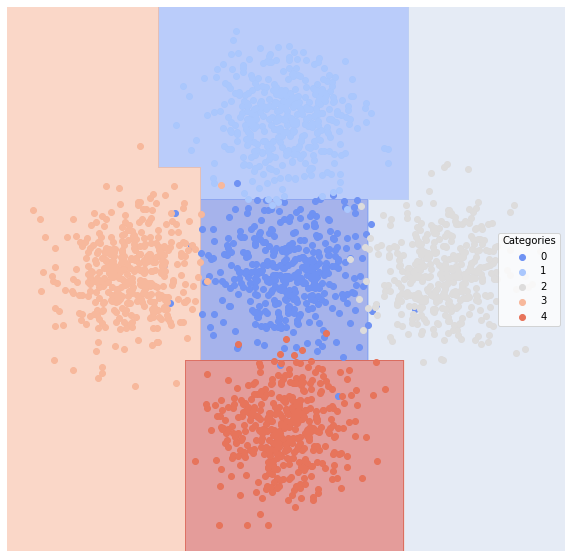

In [82]:
lucem_illud_2020.plotregions(clf_tree, df_exampleTree_train)

In [83]:
lucem_illud_2020.evaluateClassifier(clf_tree, df_exampleTree_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.022,0.971070,0.931373,0.901741,0.959596
1,0.000,1.000000,1.000000,1.000000,1.000000
2,0.004,0.997487,0.980769,0.980769,1.000000
3,0.014,0.972978,0.979798,0.941769,0.950980
4,0.008,0.982976,0.989247,0.964008,0.968421


Lets look at accuracy:

In [84]:
sklearn.metrics.accuracy_score(df_exampleTree_test['category'],clf_tree.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))

0.976

What happens if we trim the tree?

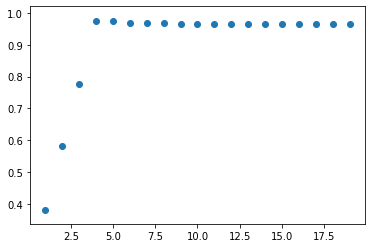

In [85]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])
    score = sklearn.metrics.accuracy_score(df_exampleTree_test['category'], tree2.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

We can select different layers of the decision tree or "prune" it. At approximately four layers down in the decision tree, the shape is somewhat odd, suggesting that our model is overfitting beyond those four layers.

Combining multiple overfitting estimators turns out to be a key idea in machine learning. This is called **bagging** and is a type of **ensemble** method. The idea is to make many randomized estimators--each can overfit, as decision trees are wont to do--but then to combine them, ultimately producing a better classification. A **random forest** is produced by bagging decision trees.

In [86]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [87]:
bag.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category']) #Fit the bagged classifier

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=10,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,
  

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

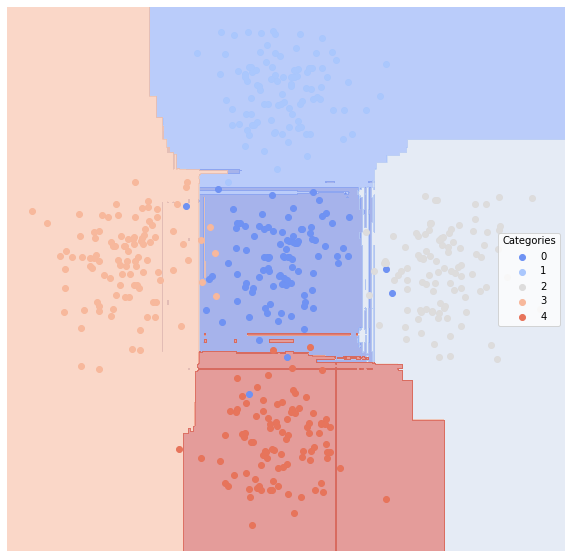

In [88]:
lucem_illud_2020.plotregions(bag, df_exampleTree_test)

In [89]:
lucem_illud_2020.evaluateClassifier(bag, df_exampleTree_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.032,0.957228,0.902913,0.860191,0.939394
1,0.002,0.998744,0.990291,0.990291,1.000000
2,0.008,0.987684,0.980392,0.965169,0.980392
3,0.014,0.972978,0.979798,0.941769,0.950980
4,0.012,0.976478,0.978495,0.945295,0.957895


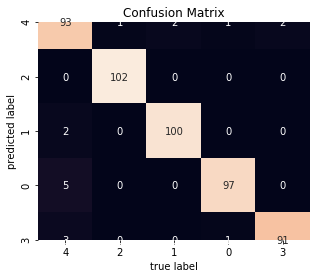

In [90]:
lucem_illud_2020.plotConfusionMatrix(bag, df_exampleTree_test)

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">In the cells immediately following, perform decision tree and random forest classification (binary, multinomial or continuous) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. As with ***Exercise 2***, these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week. Visualize the classification of data points. Calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Now build an ensemble classifier by bagging trees into a random forest. Visualize the result. How do these classifiers perform? What does ensemble learning do?

Precision
0.20833333333333334
Recall
0.18036072144288579
F measure
0.1933404940923738
Accuracy score
0.7292718096611391
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
False       0.270728  0.516848   0.849670           0.848727  0.825363
True        0.270728  0.516848   0.180361           0.160863  0.208333


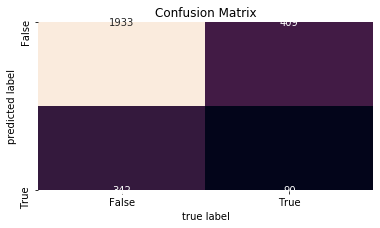

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


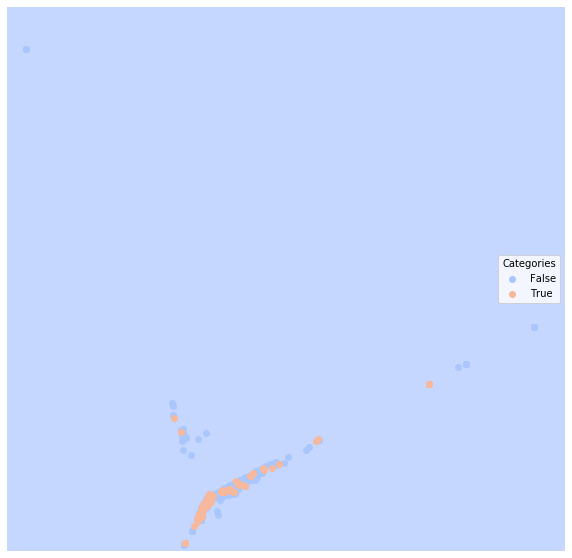

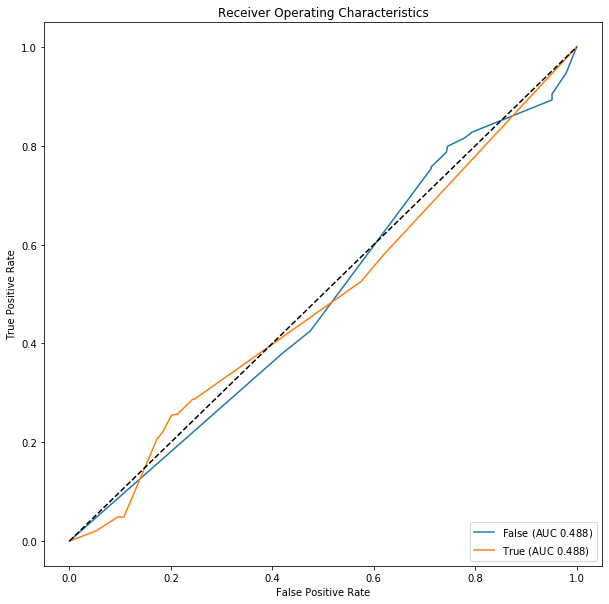

In [237]:
#decision tree
tree = sklearn.tree.DecisionTreeClassifier(max_depth=5,random_state=0)
tree.fit(np.stack(train_sentiment['vect'], axis =0), train_sentiment['category'])

test_sentiment['tree_predict']= tree.predict(np.stack(test_sentiment['vect'], axis=0))
print("Precision")
print(sklearn.metrics.precision_score(test_sentiment['tree_predict'], test_sentiment['category']))
print("Recall")
print(sklearn.metrics.recall_score(test_sentiment['tree_predict'], test_sentiment['category']))
print("F measure")
print(sklearn.metrics.f1_score(test_sentiment['tree_predict'], test_sentiment['category']))

print("Accuracy score")
print(tree.score(np.stack(test_sentiment['vect'], axis=0), test_sentiment['category']))
print(lucem_illud_2020.evaluateClassifier(tree, test_sentiment))
lucem_illud_2020.plotConfusionMatrix(tree, test_sentiment)
lucem_illud_2020.plotregions(tree, test_sentiment)
lucem_illud_2020.plotMultiROC(tree, test_sentiment)


Precision:
0.18287037037037038
Recall:
0.246875
F1:
0.21010638297872342
testing data accuracy score:
0.7858687815428983
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
False       0.214131  0.539983   0.856153           0.854930  0.897096
True        0.214131  0.539983   0.246875           0.172399  0.182870


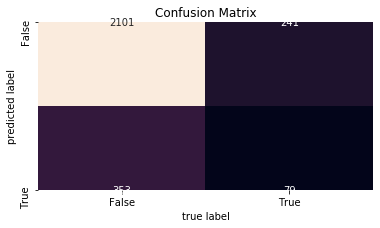

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


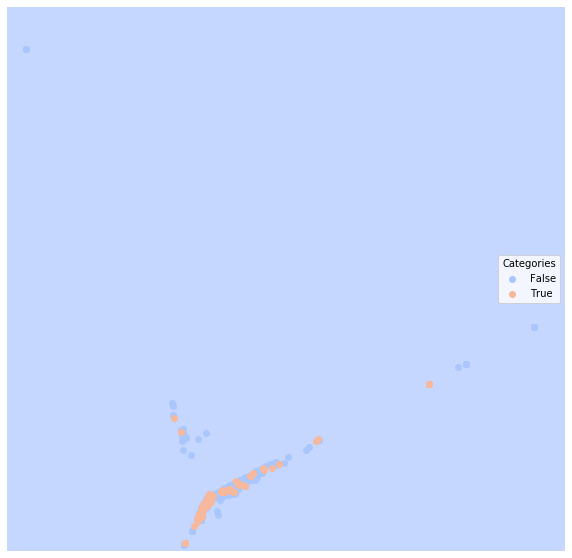

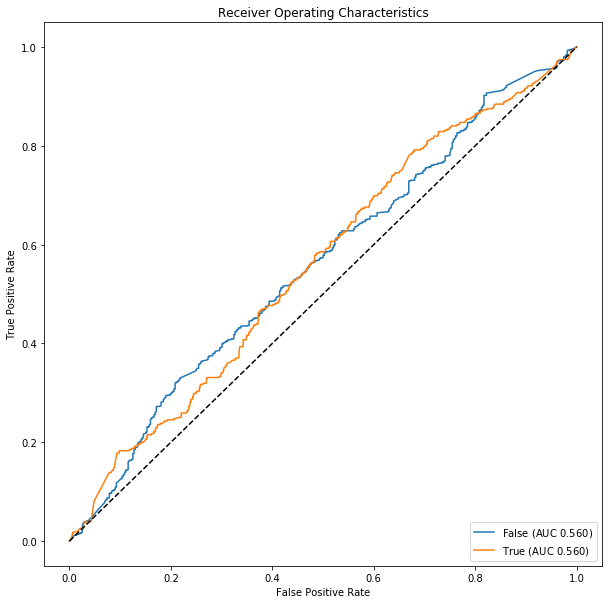

In [238]:
#random forest
trees = sklearn.tree.DecisionTreeClassifier(max_depth=5)
bag = sklearn.ensemble.BaggingClassifier(trees, n_estimators=100, max_samples=0.8, random_state=1) 

bag.fit(np.stack(train_sentiment['vect'],axis = 0),train_sentiment['category'] )

test_sentiment['bag_predict'] = bag.predict(np.stack(test_sentiment['vect'], axis=0))
print("Precision:")
print(sklearn.metrics.precision_score(test_sentiment['bag_predict'], test_sentiment['category']))
print("Recall:")
print(sklearn.metrics.recall_score(test_sentiment['bag_predict'], test_sentiment['category']))
print("F1:")
print(sklearn.metrics.f1_score(test_sentiment['bag_predict'], test_sentiment['category']
))
##evaluating
print("testing data accuracy score:")
print(bag.score(np.stack(test_sentiment['vect'], axis=0), test_sentiment['category']))
print(lucem_illud_2020.evaluateClassifier(bag, test_sentiment))
lucem_illud_2020.plotConfusionMatrix(bag, test_sentiment)
lucem_illud_2020.plotregions(bag, test_sentiment)
lucem_illud_2020.plotMultiROC(bag, test_sentiment)


Both decision tree and random forest classifiers have lower error rates and higher AUC values than logistical regression and Naive Bayes classifiers. Since a random forest is based on ensemble learning, it is built on combining and overfitting layers of decision tree estimators, which then improve the performance of the classifier classification and then classification results. The results for these two classifiers show that building a random forest from bagging decisions trees does improve the performance of a decision tree by lowering the error rates, AUC values, precision, as well as F - measure and accuracy scores. 

# K-Nearest Neighbors

The K-Nearest neighbors classifier takes a simpler premise than those before: Find the closest labeled datapoint in set and "borrow" its label.

Let's use newsgroup data again.

In [91]:
newsgroupsDF[:5]

,text,category,source_file,tokenized_text,normalized_text
0,\n\nParadise and salvation are not the same th...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[Paradise, and, salvation, are, not, the, same...","[paradise, salvation, thing, salvation, better..."
1,\nYou're admitting a lot more than that. You ...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[You, 're, admitting, a, lot, more, than, that...","[admit, lot, admit, moral, situational, admit,..."
2,"\n\nJesus also recognized other holy days, lik...",talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[Jesus, also, recognized, other, holy, days, l...","[jesus, recognize, holy, day, like, passover, ..."
3,In <lsjc8cINNmc1@saltillo.cs.utexas.edu> turpi...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[In, <, lsjc8cINNmc1@saltillo.cs.utexas.edu, >...","[<, lsjc8cinnmc1@saltillo.cs.utexas.edu, >, tu..."
4,"\nI'm sorry, but He does not! Ever read the F...",talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[I, 'm, sorry, but, He, does, not, Ever, read,...","[m, sorry, read, commandment]"


Make a testing and training set:

In [92]:
holdBackFraction = .2
train_ng_df, test_ng_df = lucem_illud_2020.trainTestSplit(newsgroupsDF, holdBackFraction=holdBackFraction)

Let's initialize our k-nearest neighbors classifier:

In [93]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

Let's try to classify using the TF-IDF vectors:

In [94]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

In [95]:
clf_knearest.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='uniform')

In [96]:
lucem_illud_2020.evaluateClassifier(clf_knearest, train_ng_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
comp.graphics,0.389437,0.508356,0.279412,0.270977,0.288503
talk.religion.misc,0.536854,0.560067,0.204373,0.196091,0.709571
soc.religion.christian,0.275682,0.502096,1.000000,0.279875,0.004193
sci.space,0.204875,0.654120,0.834197,0.464945,0.334025


And lets look at the testing data

In [97]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = clf_knearest.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Testing score:
0.19767441860465115


Let's produce another confusion matrix:

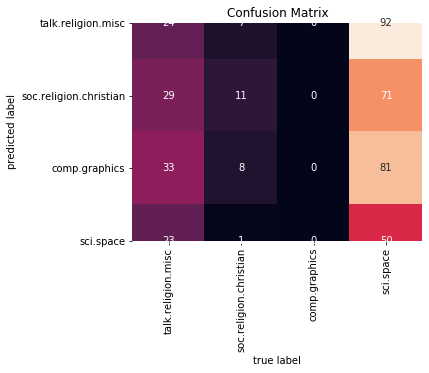

In [98]:
lucem_illud_2020.plotConfusionMatrix(clf_knearest, test_ng_df)

You can produce the PCA space visual if you want, altough it can take a very long time, so we'll leave it optionally commented out:

In [99]:
#lucem_illud_2020.plotregions(clf_knearest, test_ng_df)

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">In the cells immediately following, perform and visualize k-nearest neighbor classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. Visualize the classification of data points and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Articulate how the *k*-nearest neighbor approach relates to *k*-means clustering explored in ***week 3***?

Precision
0.04398148148148148
Recall
0.14615384615384616
F measure
0.06761565836298933
accuracy score
0.8111031002162942
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
False       0.188897  0.498293   0.843797           0.843820  0.952605
True        0.188897  0.498293   0.146154           0.155311  0.043981


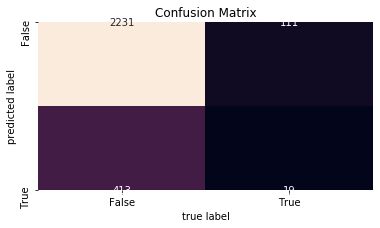

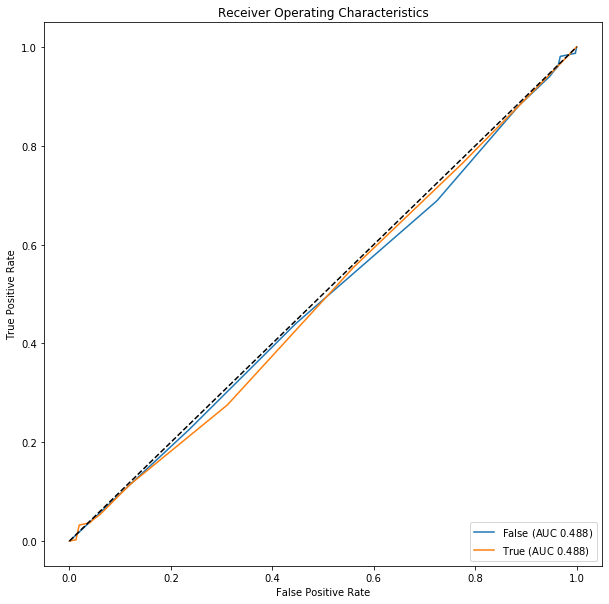

In [241]:
n_neighbors = 10
weights="uniform"

k = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
k.fit(np.stack(train_sentiment['vect'], axis = 0), train_sentiment['category'])
test_sentiment['k_predict'] = k.predict(np.stack(test_sentiment['vect'],axis=0))

print("Precision")
print(sklearn.metrics.precision_score(test_sentiment['k_predict'], test_sentiment['category']))
print("Recall")
print(sklearn.metrics.recall_score(test_sentiment['k_predict'], test_sentiment['category']))
print("F measure")
print(sklearn.metrics.f1_score(test_sentiment['k_predict'], test_sentiment['category']))

print("accuracy score")
print(k.score(np.stack(test_sentiment['vect'], axis=0), test_sentiment['category']))
print(lucem_illud_2020.evaluateClassifier(k, test_sentiment))
lucem_illud_2020.plotConfusionMatrix(k, test_sentiment)
lucem_illud_2020.plotMultiROC(k, test_sentiment)


The k nearest neighbor classification also doesn't perform very well as it produces a low precision score and relatively low AUC values, even though its error rates are not very high. While both k-nearest neighbor and k-means clustering are focusing on identifiying clustersta of da, the k-nearest neighbor approach is a supervised approach that looks at the labels of each point's neighbors, whereaas the k-means approach is an unsupervised approach that puts unlabeled points into clusters.

# SVMs

Now we will examine Support Vector Machines, an approach that creates the partition that preserves the "maximum margin" between classes.

We will use a few sub forums from reddit--which tend to share text rather than memes--namely `talesfromtechsupport`, `badroommates`, `weeabootales` and `relationships`. The top 100 text posts from each have been saved to `data/reddit.csv`.

In [101]:
redditDf = pandas.read_csv('../data/reddit.csv', index_col = 0)

#Drop a couple missing values

redditDf = redditDf.dropna()

#Set category

redditDf['category'] = redditDf['subreddit']

#tokenize and normalize
redditDf['tokenized_text'] = redditDf['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
redditDf['normalized_text'] = redditDf['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

We will tf.idf the data to make our vectors:

In [102]:
redditTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
redditTFVects = redditTFVectorizer.fit_transform([' '.join(l) for l in redditDf['normalized_text']])
redditDf['vect'] = [np.array(v).flatten() for v in redditTFVects.todense()]

Initilize the model and make a train test split:

In [103]:
holdBackFraction = .2
train_redditDf, test_redditDf = lucem_illud_2020.trainTestSplit(redditDf, holdBackFraction=holdBackFraction)

In [104]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability = False)
#probability = True is slower but  lets you call predict_proba()
clf_svm.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

...and consider the results:

In [105]:
lucem_illud_2020.evaluateClassifier(clf_svm, test_redditDf)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Tales From Tech Support,0.000000,1.000000,1.000000,1.000000,1.000000
Weeaboo Tales: stories about the extreme fans of japanese culture,0.003135,0.993590,1.000000,0.990314,0.987179
Bad Roommates: Tales of Irritation,0.012539,0.987421,0.962963,0.953908,0.987342
Relationships,0.015674,0.977066,0.974684,0.947537,0.962500


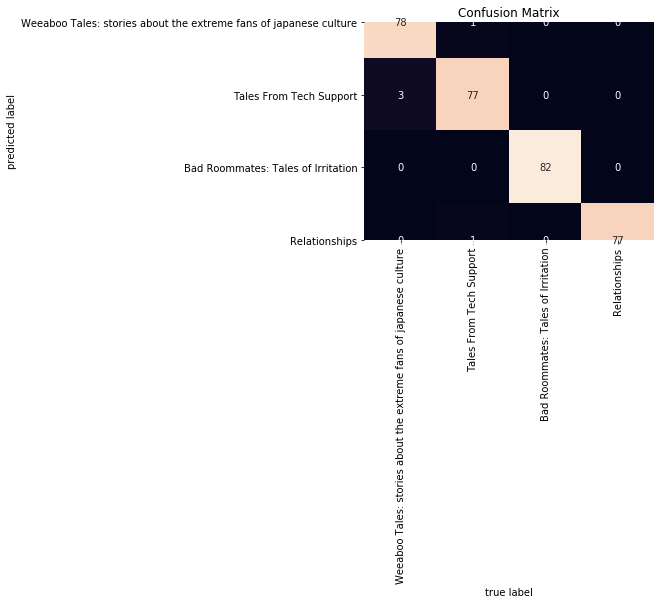

In [106]:
lucem_illud_2020.plotConfusionMatrix(clf_svm, test_redditDf)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

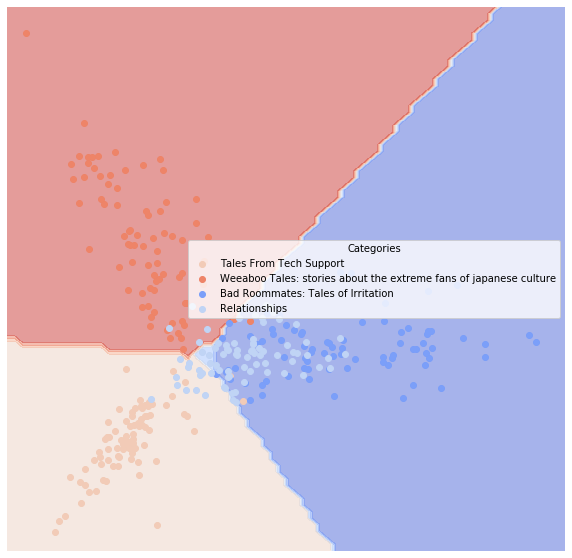

In [107]:
lucem_illud_2020.plotregions(clf_svm, test_redditDf)

# Neural Nets

We include an example of a simple neural network, the Multi-layer Perceptron (MLP) that learns a function $f(\cdot): R^m \rightarrow R^o$ by training on a dataset, where $m$ is the number of dimensions for input and $o$ is the number of dimensions for output. Given a set of features $X = {x_1, x_2, ..., x_m}$ and a target $y$, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. The following figure shows a one hidden layer MLP with scalar output. ![title](../data/multilayerperceptron_network.png) The leftmost layer, known as the input layer, consists of a set of "neurons" $\{x_i | x_1, x_2, ..., x_m\}$ representing the input features (e.g., weighted words). Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation $w_1x_1 + w_2x_2 + ... + w_mx_m$, followed by a non-linear activation function $g(\cdot):R \rightarrow R$ - like the logistic or hyperbolic tan function. The output layer receives the values from the last hidden layer and transforms them into output values.

In [108]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [109]:
lucem_illud_2020.evaluateClassifier(clf_nn, test_redditDf)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Tales From Tech Support,0.003135,0.993902,1.000000,0.990940,0.987805
Weeaboo Tales: stories about the extreme fans of japanese culture,0.009404,0.989440,0.974684,0.965322,0.987179
Bad Roommates: Tales of Irritation,0.025078,0.974842,0.927711,0.910494,0.974684
Relationships,0.031348,0.949974,0.960526,0.898424,0.912500


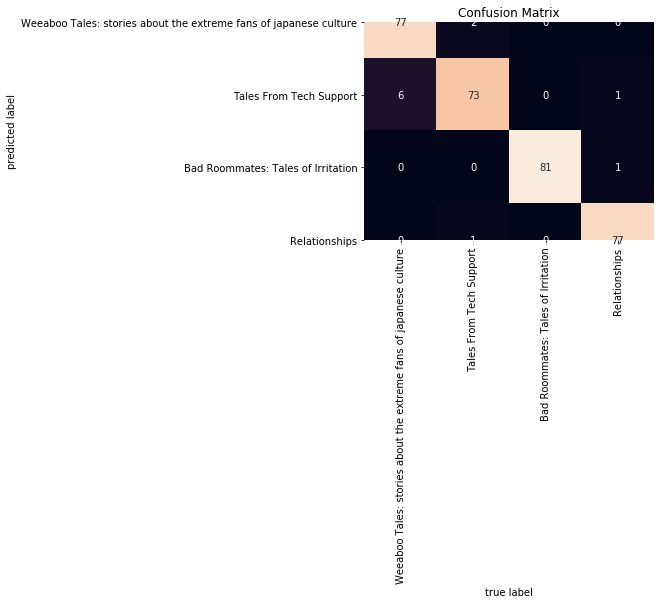

In [110]:
lucem_illud_2020.plotConfusionMatrix(clf_nn, test_redditDf)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

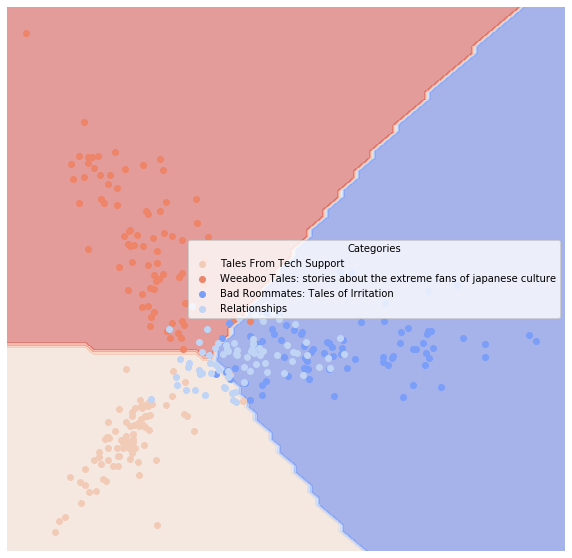

In [111]:
lucem_illud_2020.plotregions(clf_nn, test_redditDf)

It performs very well.

## <span style="color:red">*Exercise 5*</span>

<span style="color:red">In the cells immediately following, perform a neural network classification and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). How does this classify relevant to *k*-nearest neighbor, Naive Bayes, logistic and decision-tree approaches?

Precision
0.09490740740740741
Recall
0.24260355029585798
F measure
0.13643926788685526
accuracy score
0.8129055515501081
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
False       0.187094  0.520127   0.849904           0.849596  0.945346
True        0.187094  0.520127   0.242604           0.163977  0.094907


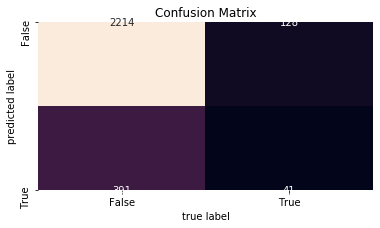

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


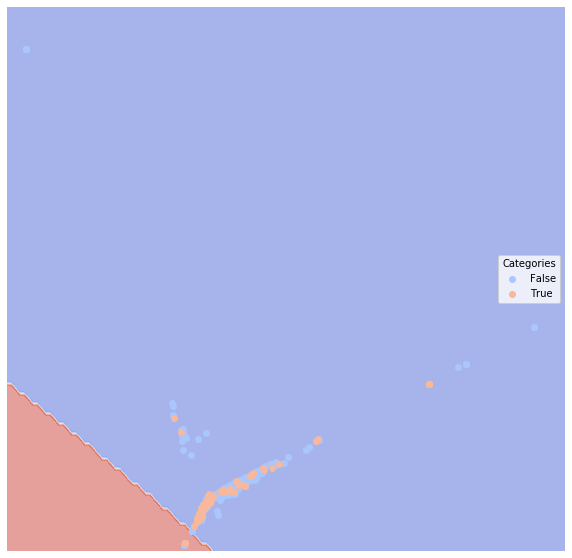

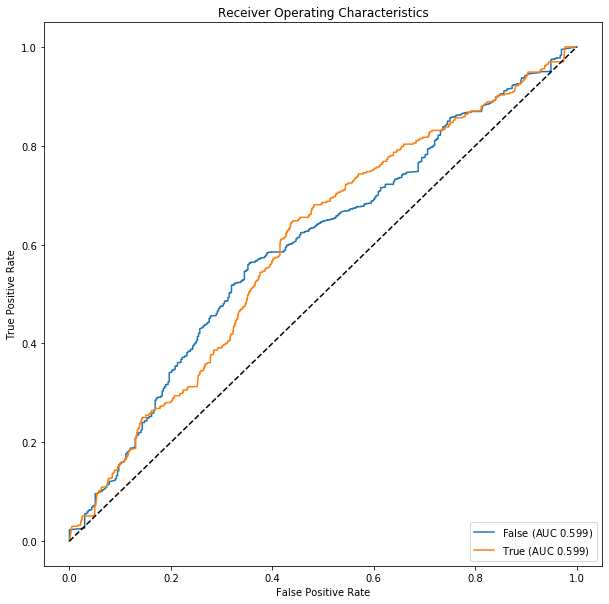

In [243]:
neural = sklearn.neural_network.MLPClassifier()
neural.fit(np.stack(train_sentiment['vect'], axis=0), train_sentiment['category'])
test_sentiment['neural_predict'] = neural.predict(np.stack(test_sentiment['vect'], axis=0))

print("Precision")
print(sklearn.metrics.precision_score(test_sentiment['neural_predict'], test_sentiment['category']))
print("Recall")
print(sklearn.metrics.recall_score(test_sentiment['neural_predict'], test_sentiment['category']))
print("F measure")
print(sklearn.metrics.f1_score(test_sentiment['neural_predict'], test_sentiment['category']))

print("accuracy score")
print(neural.score(np.stack(test_sentiment['vect'], axis=0), test_sentiment['category']))
print(lucem_illud_2020.evaluateClassifier(neural, test_sentiment))
lucem_illud_2020.plotConfusionMatrix(neural, test_sentiment)
lucem_illud_2020.plotregions(neural, test_sentiment)
lucem_illud_2020.plotMultiROC(neural, test_sentiment)



The neural network classification appears to have higher error rates than logistical and Naive Bayes classifiers, while having lower error rates than other classifiers. It has lower AUC values than the random forest classifier while having higher AUC values than others. Its accuracy score is also lower than the Naive Bayes approach. In general it has performed relatively well compared to other approaches but is not the best. However, the visualizations for operating characterics do show that this approach performs quite well in prediction. However, it should be noted that the performance of this classification model probably depends on the number and type of layers and how the values of the previous layers are weighted.